In [1]:
# Input data

import scipy.io as spio
import numpy as np

# Reading the data for the Face from all the subjects
BahramFace = spio.loadmat(file_name='../data/bci-project-data-RAW/BahramFace.mat')
DJFace = spio.loadmat(file_name='../data/bci-project-data-RAW/DJFace.mat')
NickFace = spio.loadmat(file_name='../data/bci-project-data-RAW/NickFace.mat')
RoohiFace = spio.loadmat(file_name='../data/bci-project-data-RAW/RoohiFace.mat')
SarahFace = spio.loadmat(file_name='../data/bci-project-data-RAW/SarahFace.mat')

# Deviding the input data into train and validation
# For creating the training and testing set, 30% percent of each subject is considered as test and
# 70% of each subject is conidered as training.
length = int(BahramFace['Intensification_Data'].shape[0] * 0.30)
# length

FacesDataAll = np.vstack(tup=(BahramFace['Intensification_Data'][:], 
                       DJFace['Intensification_Data'][:], 
                       NickFace['Intensification_Data'][:],
                      RoohiFace['Intensification_Data'][:],
                      SarahFace['Intensification_Data'][:]))

FacesDataTrainAll = np.vstack(tup=(BahramFace['Intensification_Data'][:-length], 
                       DJFace['Intensification_Data'][:-length], 
                       NickFace['Intensification_Data'][:-length],
                      RoohiFace['Intensification_Data'][:-length],
                      SarahFace['Intensification_Data'][:-length]))

FacesDataTest = np.vstack(tup=(BahramFace['Intensification_Data'][-length:], 
                       DJFace['Intensification_Data'][-length:], 
                       NickFace['Intensification_Data'][-length:],
                      RoohiFace['Intensification_Data'][-length:],
                      SarahFace['Intensification_Data'][-length:]))

print(FacesDataAll.shape, FacesDataAll.dtype, 
 FacesDataTest.shape, FacesDataTest.dtype, 
 FacesDataTrainAll.shape, FacesDataTrainAll.dtype)

BahramFaceDataTrain = BahramFace['Intensification_Data'][:-length]
DJFaceDataTrain = DJFace['Intensification_Data'][:-length]
NickFaceDataTrain = NickFace['Intensification_Data'][:-length]
RoohiFaceDataTrain = RoohiFace['Intensification_Data'][:-length]
SarahFaceDataTrain = SarahFace['Intensification_Data'][:-length]

# 30% of the total training data is validation,
# 70% of the total training data is training
# This is applied to every single subject data.
length2 = int(BahramFaceDataTrain.shape[0] * 0.30)
# length2

FacesDataTrain = np.vstack(tup=(BahramFaceDataTrain[:-length2], 
                       DJFaceDataTrain[:-length2], 
                       NickFaceDataTrain[:-length2],
                      RoohiFaceDataTrain[:-length2],
                      SarahFaceDataTrain[:-length2]))

FacesDataValid = np.vstack(tup=(BahramFaceDataTrain[-length2:], 
                       DJFaceDataTrain[-length2:], 
                       NickFaceDataTrain[-length2:],
                      RoohiFaceDataTrain[-length2:],
                      SarahFaceDataTrain[-length2:]))

print(FacesDataTrainAll.shape, FacesDataTrainAll.dtype, 
 FacesDataTrain.shape, FacesDataTrain.dtype, 
 FacesDataValid.shape, FacesDataValid.dtype)

FacesLabelAll = np.vstack(tup=(BahramFace['Intensification_Label'][:], 
                       DJFace['Intensification_Label'][:], 
                       NickFace['Intensification_Label'][:],
                      RoohiFace['Intensification_Label'][:],
                      SarahFace['Intensification_Label'][:]))

FacesLabelTrainAll = np.vstack(tup=(BahramFace['Intensification_Label'][:-length], 
                       DJFace['Intensification_Label'][:-length], 
                       NickFace['Intensification_Label'][:-length],
                      RoohiFace['Intensification_Label'][:-length],
                      SarahFace['Intensification_Label'][:-length]))

FacesLabelTest = np.vstack(tup=(BahramFace['Intensification_Label'][-length:], 
                       DJFace['Intensification_Label'][-length:], 
                       NickFace['Intensification_Label'][-length:],
                      RoohiFace['Intensification_Label'][-length:],
                      SarahFace['Intensification_Label'][-length:]))

print(FacesLabelAll.shape, FacesLabelAll.dtype,
 FacesLabelTest.shape, FacesLabelTest.dtype, 
 FacesLabelTrainAll.shape, FacesLabelTrainAll.dtype)

BahramFaceLabelTrain = BahramFace['Intensification_Label'][:-length]
DJFaceLabelTrain = DJFace['Intensification_Label'][:-length]
NickFaceLabelTrain = NickFace['Intensification_Label'][:-length]
RoohiFaceLabelTrain = RoohiFace['Intensification_Label'][:-length]
SarahFaceLabelTrain = SarahFace['Intensification_Label'][:-length]

FacesLabelTrain = np.vstack(tup=(BahramFaceLabelTrain[:-length2], 
                       DJFaceLabelTrain[:-length2], 
                       NickFaceLabelTrain[:-length2],
                      RoohiFaceLabelTrain[:-length2],
                      SarahFaceLabelTrain[:-length2]))

FacesLabelValid = np.vstack(tup=(BahramFaceLabelTrain[-length2:], 
                       DJFaceLabelTrain[-length2:], 
                       NickFaceLabelTrain[-length2:],
                      RoohiFaceLabelTrain[-length2:],
                      SarahFaceLabelTrain[-length2:]))

# # Normalizing input data
# def normalize(inputs, inputs_all):
#     return (inputs - inputs_all.mean(axis=0)[None,:,:]) / inputs_all.std(axis=0)[None,:,:]
# Yalda suggested this normalization.
def normalize(inputs):
    return (inputs - inputs.mean(axis=0)[None,:,:]) / inputs.std(axis=0)[None,:,:]

# onehot vectorizing output labels
def one_hot(labels, n_class):
    """ One-hot encoding """
    expansion = np.eye(n_class)
    y = expansion[:, labels-1].T
    assert y.shape[1] == n_class, "Wrong number of labels!"

    return y

# get minibatches for learning
def get_batches(X, y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, y = X[:n_batches*batch_size], y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], y[b:b+batch_size]

# Standardize/normalize train and test
# X_train_norm_all = normalize(inputs=FacesDataTrain, inputs_all=FacesDataAll)
X_train_norm = normalize(inputs=FacesDataTrain)
X_valid_norm = normalize(inputs=FacesDataValid)
X_test_norm = normalize(inputs=FacesDataTest)

print(X_train_norm.shape, X_train_norm.dtype, 
X_valid_norm.shape, X_valid_norm.dtype,
X_test_norm.shape, X_test_norm.dtype)

### Hyperparameters

# Input data
batch_size = X_train_norm.shape[0]// 100 # minibatch size & number of minibatches
seq_len = X_train_norm.shape[1] # Number of steps: each trial length
n_channels = X_train_norm.shape[2] # number of channels in each trial

# Output labels
n_classes = int(FacesLabelAll.max() + 1)

# Tweekable parameters
learning_rate = 0.001 #1e-3
epochs = 100 # num iterations for updating model
keep_prob = 0.50 # 90% neurons are kept and 10% are dropped out

Y_train = np.array(FacesLabelTrain, dtype=int).reshape(-1)
Y_valid = np.array(FacesLabelValid, dtype=int).reshape(-1)
Y_test = np.array(FacesLabelTest, dtype=int).reshape(-1)

Y_train_onehot = one_hot(labels=Y_train, n_class=n_classes)
Y_valid_onehot = one_hot(labels=Y_valid, n_class=n_classes)
Y_test_onehot = one_hot(labels=Y_test, n_class=n_classes)

print(Y_train_onehot.shape, Y_valid_onehot.shape, Y_test_onehot.shape, 
 X_train_norm.shape, X_valid_norm.shape, X_test_norm.shape)

print(Y_train_onehot.dtype, Y_valid_onehot.dtype, Y_test_onehot.dtype,
 X_train_norm.dtype, X_valid_norm.dtype, X_test_norm.dtype)

# GPUs or CPU

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

#  No graphs is needed on tensorflow
inputs_ = tf.placeholder(tf.float32, [None, seq_len, n_channels], name = 'inputs_')
labels_ = tf.placeholder(tf.float32, [None, n_classes], name = 'labels_')
keep_prob_ = tf.placeholder(tf.float32, name = 'keep_prob_')
learning_rate_ = tf.placeholder(tf.float32, name = 'learning_rate_')# Construct the LSTM inputs and LSTM cells

(18720, 205, 16) float64 (5400, 205, 16) float64 (13320, 205, 16) float64
(13320, 205, 16) float64 (9540, 205, 16) float64 (3780, 205, 16) float64
(18720, 1) uint8 (5400, 1) uint8 (13320, 1) uint8
(9540, 205, 16) float64 (3780, 205, 16) float64 (5400, 205, 16) float64
(9540, 2) (3780, 2) (5400, 2) (9540, 205, 16) (3780, 205, 16) (5400, 205, 16)
float64 float64 float64 float64 float64 float64
TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


In [2]:
# Forward pass: Convolutional Layers, FC Layer, and Output layer
# (batch, 205, 16) --> (batch, 101, 32)
# (205 - 5 + 0)/2 + 1 = 100+1= 101
# 2/5 with strides/kernel_size is 40% non-overlap/diff region and 60% overlapping window/ common region
in_conv = inputs_
out_conv = tf.layers.conv1d(inputs=in_conv, filters=32, kernel_size=5, strides=2, padding='valid')
out_conv = tf.layers.batch_normalization(inputs=out_conv)
out_conv = tf.nn.relu(features=out_conv)
out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(out_conv.shape)

# (batch, 101, 32) --> (batch, 49, 64)
# (101 - 5 + 0)/2 + 1 = (96/2)+1= 48+1= 49
# 2/5 with strides/kernel_size is 40% non-overlap/diff region and 60% overlapping window/ common region
in_conv = out_conv
out_conv = tf.layers.conv1d(inputs=in_conv, filters=64, kernel_size=5, strides=2, padding='valid')
out_conv = tf.layers.batch_normalization(inputs=out_conv)
out_conv = tf.nn.relu(features=out_conv)
out_conv = tf.nn.dropout(x=out_conv, keep_prob=keep_prob_)
print(out_conv.shape)

# (batch, 49, 64) --> (batch, 49*64) --> (batch, 49*64*2)
# 49*64 = 50*64 - 1*64 = 3200 - 64 = 3136, 3136*2 = 6272
# (batch, 49, 64) --> (batch, 3200) --> (batch, 6272)
in_fc = tf.reshape(tensor=out_conv, shape=(-1, 49*64))
out_fc = tf.layers.dense(inputs=in_fc, units=49*64*2)
out_fc = tf.layers.batch_normalization(inputs=out_fc)
out_fc = tf.nn.relu(features=out_fc)
out_fc = tf.nn.dropout(x=out_fc, keep_prob=keep_prob_)
print(in_fc.shape, out_fc.shape)

# (batch, 49*64*2) --> (batch, 2) 
logits = tf.layers.dense(inputs=out_fc, units=n_classes)
print(logits.shape)

(?, 101, 32)
(?, 49, 64)
(?, 3136) (?, 6272)
(?, 2)


In [3]:
# Backward pass: error backpropagation
# Cost function
cost_tensor = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels_)
cost = tf.reduce_mean(input_tensor=cost_tensor)

# Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate_).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [4]:
# Train the network
# Plotting the acc and loss curve
train_acc = []
train_loss = []

valid_acc = []
valid_loss = []

with tf.Session() as sess:
    # initalize session global variables just in the case they are initialized.
    sess.run(tf.global_variables_initializer())
    
    for e in range(epochs):
       
        # Loop over batches
        for x, y in get_batches(X_train_norm, Y_train_onehot, batch_size):
            
            # Feed dictionary
            feed = {inputs_:x, labels_:y, keep_prob_: keep_prob, learning_rate_:learning_rate}
            loss, _ , acc = sess.run([cost, optimizer, accuracy], feed_dict = feed)
            
            train_acc.append(acc)
            train_loss.append(loss)
            
            ################################ Validation
            # Initialize 
            loss_v_batch, acc_v_batch = [], []

            # Loop over batches
            for x_v, y_v in get_batches(X_valid_norm, Y_valid_onehot, batch_size):

                # Feed dictionary
                feed = {inputs_:x_v, labels_:y_v, keep_prob_: 1.0}
                loss_v, acc_v = sess.run([cost, accuracy], feed_dict = feed)
                
                acc_v_batch.append(acc_v)
                loss_v_batch.append(loss_v)
                
            valid_acc.append(np.mean(acc_v_batch))
            valid_loss.append(np.mean(loss_v_batch))
            
            # Print info
            print("Epoch: {}/{}".format(e+1, epochs),
                  "Train loss: {:6f}".format(loss),
                  "Valid loss: {:.6f}".format(np.mean(valid_loss)),
                  "Train acc: {:6f}".format(acc),
                  "Valid acc: {:.6f}".format(np.mean(valid_acc)))
            
    ################################ Test
    # Initialize 
    acc_batch, loss_batch = [], []

    # Loop over batches
    for x, y in get_batches(X_test_norm, Y_test_onehot, batch_size):

        # Feed dictionary
        feed = {inputs_:x, labels_:y, keep_prob_:1.0}
        loss, acc = sess.run([cost, accuracy], feed_dict = feed)

        acc_batch.append(acc)
        loss_batch.append(loss)

    # Print info
    print("Epoch: {}/{}".format(e+1, epochs),
          "Test loss: {:6f}".format(np.mean(loss_batch)),
          "Test acc: {:6f}".format(np.mean(acc_batch)))

Epoch: 1/100 Train loss: 0.790437 Valid loss: 5.499231 Train acc: 0.347368 Valid acc: 0.833468
Epoch: 1/100 Train loss: 4.050720 Valid loss: 5.257221 Train acc: 0.842105 Valid acc: 0.833468
Epoch: 1/100 Train loss: 3.848777 Valid loss: 4.601801 Train acc: 0.831579 Valid acc: 0.833468
Epoch: 1/100 Train loss: 2.766085 Valid loss: 3.898152 Train acc: 0.831579 Valid acc: 0.833468
Epoch: 1/100 Train loss: 1.627522 Valid loss: 3.288175 Train acc: 0.831579 Valid acc: 0.833468
Epoch: 1/100 Train loss: 0.882550 Valid loss: 2.818504 Train acc: 0.831579 Valid acc: 0.833468
Epoch: 1/100 Train loss: 0.485158 Valid loss: 2.491574 Train acc: 0.831579 Valid acc: 0.833468
Epoch: 1/100 Train loss: 0.483641 Valid loss: 2.262628 Train acc: 0.831579 Valid acc: 0.825810
Epoch: 1/100 Train loss: 0.581437 Valid loss: 2.090338 Train acc: 0.821053 Valid acc: 0.768211
Epoch: 1/100 Train loss: 0.651292 Valid loss: 1.952487 Train acc: 0.736842 Valid acc: 0.719973
Epoch: 1/100 Train loss: 0.666360 Valid loss: 1.83

Epoch: 1/100 Train loss: 1.562363 Valid loss: 0.637739 Train acc: 0.831579 Valid acc: 0.816630
Epoch: 1/100 Train loss: 0.570850 Valid loss: 0.636218 Train acc: 0.831579 Valid acc: 0.816819
Epoch: 1/100 Train loss: 0.546947 Valid loss: 0.635001 Train acc: 0.842105 Valid acc: 0.817019
Epoch: 1/100 Train loss: 0.468038 Valid loss: 0.634006 Train acc: 0.821053 Valid acc: 0.817212
Epoch: 1/100 Train loss: 0.480687 Valid loss: 0.633152 Train acc: 0.831579 Valid acc: 0.817415
Epoch: 1/100 Train loss: 0.498888 Valid loss: 0.632373 Train acc: 0.831579 Valid acc: 0.817625
Epoch: 1/100 Train loss: 0.480740 Valid loss: 0.631610 Train acc: 0.852632 Valid acc: 0.817817
Epoch: 1/100 Train loss: 0.499201 Valid loss: 0.630820 Train acc: 0.821053 Valid acc: 0.818010
Epoch: 1/100 Train loss: 0.491132 Valid loss: 0.629964 Train acc: 0.842105 Valid acc: 0.818191
Epoch: 1/100 Train loss: 0.508093 Valid loss: 0.629012 Train acc: 0.831579 Valid acc: 0.818351
Epoch: 1/100 Train loss: 0.471638 Valid loss: 0.62

Epoch: 2/100 Train loss: 0.357999 Valid loss: 0.518876 Train acc: 0.842105 Valid acc: 0.836727
Epoch: 2/100 Train loss: 0.401671 Valid loss: 0.518058 Train acc: 0.842105 Valid acc: 0.836849
Epoch: 2/100 Train loss: 0.342468 Valid loss: 0.517229 Train acc: 0.842105 Valid acc: 0.836971
Epoch: 2/100 Train loss: 0.405559 Valid loss: 0.516386 Train acc: 0.821053 Valid acc: 0.837092
Epoch: 2/100 Train loss: 0.332605 Valid loss: 0.515524 Train acc: 0.852632 Valid acc: 0.837211
Epoch: 2/100 Train loss: 0.358192 Valid loss: 0.514651 Train acc: 0.831579 Valid acc: 0.837345
Epoch: 2/100 Train loss: 0.394749 Valid loss: 0.513778 Train acc: 0.831579 Valid acc: 0.837487
Epoch: 2/100 Train loss: 0.355996 Valid loss: 0.512912 Train acc: 0.831579 Valid acc: 0.837657
Epoch: 2/100 Train loss: 0.343312 Valid loss: 0.512062 Train acc: 0.831579 Valid acc: 0.837856
Epoch: 2/100 Train loss: 0.354030 Valid loss: 0.511234 Train acc: 0.842105 Valid acc: 0.838076
Epoch: 2/100 Train loss: 0.334540 Valid loss: 0.51

Epoch: 3/100 Train loss: 0.472391 Valid loss: 0.469966 Train acc: 0.821053 Valid acc: 0.843974
Epoch: 3/100 Train loss: 0.516931 Valid loss: 0.469593 Train acc: 0.821053 Valid acc: 0.844162
Epoch: 3/100 Train loss: 0.540088 Valid loss: 0.469239 Train acc: 0.831579 Valid acc: 0.844343
Epoch: 3/100 Train loss: 0.470026 Valid loss: 0.468911 Train acc: 0.821053 Valid acc: 0.844520
Epoch: 3/100 Train loss: 0.451147 Valid loss: 0.468610 Train acc: 0.821053 Valid acc: 0.844694
Epoch: 3/100 Train loss: 0.473378 Valid loss: 0.468338 Train acc: 0.831579 Valid acc: 0.844866
Epoch: 3/100 Train loss: 0.412911 Valid loss: 0.468092 Train acc: 0.831579 Valid acc: 0.845034
Epoch: 3/100 Train loss: 0.448918 Valid loss: 0.467864 Train acc: 0.789474 Valid acc: 0.845202
Epoch: 3/100 Train loss: 0.395738 Valid loss: 0.467646 Train acc: 0.852632 Valid acc: 0.845363
Epoch: 3/100 Train loss: 0.455693 Valid loss: 0.467441 Train acc: 0.842105 Valid acc: 0.845520
Epoch: 3/100 Train loss: 0.334955 Valid loss: 0.46

Epoch: 4/100 Train loss: 0.409868 Valid loss: 0.439685 Train acc: 0.852632 Valid acc: 0.851584
Epoch: 4/100 Train loss: 0.413352 Valid loss: 0.439481 Train acc: 0.831579 Valid acc: 0.851654
Epoch: 4/100 Train loss: 0.337986 Valid loss: 0.439258 Train acc: 0.884211 Valid acc: 0.851736
Epoch: 4/100 Train loss: 0.376967 Valid loss: 0.439018 Train acc: 0.831579 Valid acc: 0.851820
Epoch: 4/100 Train loss: 0.446781 Valid loss: 0.438768 Train acc: 0.821053 Valid acc: 0.851904
Epoch: 4/100 Train loss: 0.416001 Valid loss: 0.438509 Train acc: 0.810526 Valid acc: 0.851987
Epoch: 4/100 Train loss: 0.308782 Valid loss: 0.438240 Train acc: 0.873684 Valid acc: 0.852075
Epoch: 4/100 Train loss: 0.413514 Valid loss: 0.437969 Train acc: 0.800000 Valid acc: 0.852162
Epoch: 4/100 Train loss: 0.333350 Valid loss: 0.437693 Train acc: 0.831579 Valid acc: 0.852247
Epoch: 4/100 Train loss: 0.345499 Valid loss: 0.437418 Train acc: 0.842105 Valid acc: 0.852336
Epoch: 4/100 Train loss: 0.270783 Valid loss: 0.43

Epoch: 5/100 Train loss: 0.126564 Valid loss: 0.419345 Train acc: 0.947369 Valid acc: 0.856574
Epoch: 5/100 Train loss: 0.464286 Valid loss: 0.419121 Train acc: 0.842105 Valid acc: 0.856605
Epoch: 5/100 Train loss: 0.520017 Valid loss: 0.418905 Train acc: 0.821053 Valid acc: 0.856635
Epoch: 5/100 Train loss: 0.358502 Valid loss: 0.418698 Train acc: 0.842105 Valid acc: 0.856664
Epoch: 5/100 Train loss: 0.436042 Valid loss: 0.418505 Train acc: 0.831579 Valid acc: 0.856692
Epoch: 5/100 Train loss: 0.382507 Valid loss: 0.418333 Train acc: 0.821053 Valid acc: 0.856719
Epoch: 5/100 Train loss: 0.407304 Valid loss: 0.418182 Train acc: 0.852632 Valid acc: 0.856741
Epoch: 5/100 Train loss: 0.403668 Valid loss: 0.418052 Train acc: 0.842105 Valid acc: 0.856763
Epoch: 5/100 Train loss: 0.356005 Valid loss: 0.417940 Train acc: 0.852632 Valid acc: 0.856787
Epoch: 5/100 Train loss: 0.257033 Valid loss: 0.417840 Train acc: 0.894737 Valid acc: 0.856814
Epoch: 5/100 Train loss: 0.289361 Valid loss: 0.41

Epoch: 6/100 Train loss: 0.170642 Valid loss: 0.405099 Train acc: 0.936842 Valid acc: 0.860356
Epoch: 6/100 Train loss: 0.266411 Valid loss: 0.404829 Train acc: 0.926316 Valid acc: 0.860411
Epoch: 6/100 Train loss: 0.500352 Valid loss: 0.404564 Train acc: 0.873684 Valid acc: 0.860466
Epoch: 6/100 Train loss: 0.175608 Valid loss: 0.404309 Train acc: 0.915790 Valid acc: 0.860513
Epoch: 6/100 Train loss: 0.205769 Valid loss: 0.404066 Train acc: 0.894737 Valid acc: 0.860556
Epoch: 6/100 Train loss: 0.110344 Valid loss: 0.403836 Train acc: 0.968421 Valid acc: 0.860601
Epoch: 6/100 Train loss: 0.106162 Valid loss: 0.403620 Train acc: 0.968421 Valid acc: 0.860642
Epoch: 6/100 Train loss: 0.056113 Valid loss: 0.403413 Train acc: 0.989474 Valid acc: 0.860680
Epoch: 6/100 Train loss: 0.153210 Valid loss: 0.403215 Train acc: 0.936842 Valid acc: 0.860710
Epoch: 6/100 Train loss: 0.223599 Valid loss: 0.403022 Train acc: 0.926316 Valid acc: 0.860738
Epoch: 6/100 Train loss: 0.079229 Valid loss: 0.40

Epoch: 7/100 Train loss: 0.203377 Valid loss: 0.395027 Train acc: 0.915790 Valid acc: 0.862881
Epoch: 7/100 Train loss: 0.367614 Valid loss: 0.394978 Train acc: 0.821053 Valid acc: 0.862839
Epoch: 7/100 Train loss: 0.177367 Valid loss: 0.394922 Train acc: 0.947369 Valid acc: 0.862802
Epoch: 7/100 Train loss: 0.212929 Valid loss: 0.394857 Train acc: 0.936842 Valid acc: 0.862770
Epoch: 7/100 Train loss: 0.409782 Valid loss: 0.394781 Train acc: 0.810526 Valid acc: 0.862745
Epoch: 7/100 Train loss: 0.260314 Valid loss: 0.394693 Train acc: 0.936842 Valid acc: 0.862727
Epoch: 7/100 Train loss: 0.214831 Valid loss: 0.394586 Train acc: 0.905263 Valid acc: 0.862721
Epoch: 7/100 Train loss: 0.292353 Valid loss: 0.394449 Train acc: 0.905263 Valid acc: 0.862729
Epoch: 7/100 Train loss: 0.492106 Valid loss: 0.394287 Train acc: 0.831579 Valid acc: 0.862753
Epoch: 7/100 Train loss: 0.087363 Valid loss: 0.394112 Train acc: 0.957895 Valid acc: 0.862786
Epoch: 7/100 Train loss: 0.285530 Valid loss: 0.39

Epoch: 7/100 Train loss: 0.158936 Valid loss: 0.388482 Train acc: 0.936842 Valid acc: 0.864423
Epoch: 8/100 Train loss: 0.204388 Valid loss: 0.388361 Train acc: 0.905263 Valid acc: 0.864446
Epoch: 8/100 Train loss: 0.207985 Valid loss: 0.388236 Train acc: 0.884211 Valid acc: 0.864468
Epoch: 8/100 Train loss: 0.368440 Valid loss: 0.388110 Train acc: 0.884211 Valid acc: 0.864488
Epoch: 8/100 Train loss: 0.273679 Valid loss: 0.387983 Train acc: 0.894737 Valid acc: 0.864509
Epoch: 8/100 Train loss: 0.246611 Valid loss: 0.387858 Train acc: 0.894737 Valid acc: 0.864527
Epoch: 8/100 Train loss: 0.346038 Valid loss: 0.387735 Train acc: 0.894737 Valid acc: 0.864540
Epoch: 8/100 Train loss: 0.351381 Valid loss: 0.387618 Train acc: 0.852632 Valid acc: 0.864549
Epoch: 8/100 Train loss: 0.312445 Valid loss: 0.387506 Train acc: 0.884211 Valid acc: 0.864556
Epoch: 8/100 Train loss: 0.194142 Valid loss: 0.387397 Train acc: 0.926316 Valid acc: 0.864560
Epoch: 8/100 Train loss: 0.242048 Valid loss: 0.38

Epoch: 8/100 Train loss: 0.279738 Valid loss: 0.381550 Train acc: 0.894737 Valid acc: 0.865904
Epoch: 8/100 Train loss: 0.790238 Valid loss: 0.381505 Train acc: 0.905263 Valid acc: 0.865930
Epoch: 8/100 Train loss: 0.353184 Valid loss: 0.381468 Train acc: 0.842105 Valid acc: 0.865957
Epoch: 8/100 Train loss: 0.299277 Valid loss: 0.381437 Train acc: 0.852632 Valid acc: 0.865982
Epoch: 8/100 Train loss: 0.250460 Valid loss: 0.381408 Train acc: 0.926316 Valid acc: 0.866005
Epoch: 8/100 Train loss: 0.259147 Valid loss: 0.381380 Train acc: 0.884211 Valid acc: 0.866029
Epoch: 8/100 Train loss: 0.274821 Valid loss: 0.381350 Train acc: 0.873684 Valid acc: 0.866054
Epoch: 8/100 Train loss: 0.200763 Valid loss: 0.381316 Train acc: 0.936842 Valid acc: 0.866078
Epoch: 8/100 Train loss: 0.240662 Valid loss: 0.381275 Train acc: 0.894737 Valid acc: 0.866101
Epoch: 8/100 Train loss: 0.240498 Valid loss: 0.381227 Train acc: 0.915790 Valid acc: 0.866126
Epoch: 8/100 Train loss: 0.311581 Valid loss: 0.38

Epoch: 9/100 Train loss: 0.337991 Valid loss: 0.375911 Train acc: 0.884211 Valid acc: 0.867227
Epoch: 9/100 Train loss: 0.292313 Valid loss: 0.375909 Train acc: 0.873684 Valid acc: 0.867242
Epoch: 9/100 Train loss: 0.326500 Valid loss: 0.375903 Train acc: 0.863158 Valid acc: 0.867258
Epoch: 9/100 Train loss: 0.337092 Valid loss: 0.375893 Train acc: 0.884211 Valid acc: 0.867274
Epoch: 9/100 Train loss: 0.326118 Valid loss: 0.375877 Train acc: 0.863158 Valid acc: 0.867289
Epoch: 9/100 Train loss: 0.355787 Valid loss: 0.375855 Train acc: 0.821053 Valid acc: 0.867303
Epoch: 9/100 Train loss: 0.292418 Valid loss: 0.375828 Train acc: 0.863158 Valid acc: 0.867315
Epoch: 9/100 Train loss: 0.323201 Valid loss: 0.375795 Train acc: 0.852632 Valid acc: 0.867327
Epoch: 9/100 Train loss: 0.268169 Valid loss: 0.375757 Train acc: 0.894737 Valid acc: 0.867340
Epoch: 9/100 Train loss: 0.305866 Valid loss: 0.375714 Train acc: 0.831579 Valid acc: 0.867355
Epoch: 9/100 Train loss: 0.278741 Valid loss: 0.37

Epoch: 10/100 Train loss: 0.266790 Valid loss: 0.370304 Train acc: 0.884211 Valid acc: 0.868475
Epoch: 10/100 Train loss: 0.301024 Valid loss: 0.370238 Train acc: 0.873684 Valid acc: 0.868499
Epoch: 10/100 Train loss: 0.225562 Valid loss: 0.370168 Train acc: 0.884211 Valid acc: 0.868523
Epoch: 10/100 Train loss: 0.294156 Valid loss: 0.370098 Train acc: 0.842105 Valid acc: 0.868549
Epoch: 10/100 Train loss: 0.565098 Valid loss: 0.370028 Train acc: 0.821053 Valid acc: 0.868574
Epoch: 10/100 Train loss: 0.510289 Valid loss: 0.369963 Train acc: 0.810526 Valid acc: 0.868598
Epoch: 10/100 Train loss: 0.623748 Valid loss: 0.369904 Train acc: 0.789474 Valid acc: 0.868621
Epoch: 10/100 Train loss: 0.543549 Valid loss: 0.369852 Train acc: 0.747368 Valid acc: 0.868645
Epoch: 10/100 Train loss: 0.482269 Valid loss: 0.369810 Train acc: 0.810526 Valid acc: 0.868669
Epoch: 10/100 Train loss: 0.604141 Valid loss: 0.369780 Train acc: 0.768421 Valid acc: 0.868690
Epoch: 10/100 Train loss: 0.304178 Valid

Epoch: 11/100 Train loss: 0.259064 Valid loss: 0.365349 Train acc: 0.894737 Valid acc: 0.869584
Epoch: 11/100 Train loss: 0.199961 Valid loss: 0.365333 Train acc: 0.947369 Valid acc: 0.869599
Epoch: 11/100 Train loss: 0.270414 Valid loss: 0.365323 Train acc: 0.873684 Valid acc: 0.869611
Epoch: 11/100 Train loss: 0.363361 Valid loss: 0.365314 Train acc: 0.863158 Valid acc: 0.869622
Epoch: 11/100 Train loss: 0.252880 Valid loss: 0.365303 Train acc: 0.905263 Valid acc: 0.869634
Epoch: 11/100 Train loss: 0.339425 Valid loss: 0.365287 Train acc: 0.852632 Valid acc: 0.869647
Epoch: 11/100 Train loss: 0.356960 Valid loss: 0.365261 Train acc: 0.831579 Valid acc: 0.869661
Epoch: 11/100 Train loss: 0.280303 Valid loss: 0.365226 Train acc: 0.884211 Valid acc: 0.869675
Epoch: 11/100 Train loss: 0.369347 Valid loss: 0.365184 Train acc: 0.842105 Valid acc: 0.869691
Epoch: 11/100 Train loss: 0.386262 Valid loss: 0.365137 Train acc: 0.863158 Valid acc: 0.869708
Epoch: 11/100 Train loss: 0.326299 Valid

Epoch: 12/100 Train loss: 0.046971 Valid loss: 0.361791 Train acc: 0.989474 Valid acc: 0.870517
Epoch: 12/100 Train loss: 0.139491 Valid loss: 0.361724 Train acc: 0.936842 Valid acc: 0.870525
Epoch: 12/100 Train loss: 0.153984 Valid loss: 0.361658 Train acc: 0.936842 Valid acc: 0.870534
Epoch: 12/100 Train loss: 0.078661 Valid loss: 0.361592 Train acc: 0.968421 Valid acc: 0.870541
Epoch: 12/100 Train loss: 0.116013 Valid loss: 0.361529 Train acc: 0.936842 Valid acc: 0.870547
Epoch: 12/100 Train loss: 0.080790 Valid loss: 0.361466 Train acc: 0.957895 Valid acc: 0.870553
Epoch: 12/100 Train loss: 0.143738 Valid loss: 0.361405 Train acc: 0.957895 Valid acc: 0.870557
Epoch: 12/100 Train loss: 0.410021 Valid loss: 0.361344 Train acc: 0.884211 Valid acc: 0.870563
Epoch: 12/100 Train loss: 0.441817 Valid loss: 0.361286 Train acc: 0.863158 Valid acc: 0.870568
Epoch: 12/100 Train loss: 0.260139 Valid loss: 0.361229 Train acc: 0.873684 Valid acc: 0.870576
Epoch: 12/100 Train loss: 0.305427 Valid

Epoch: 13/100 Train loss: 0.203079 Valid loss: 0.358998 Train acc: 0.936842 Valid acc: 0.871004
Epoch: 13/100 Train loss: 0.257361 Valid loss: 0.358956 Train acc: 0.894737 Valid acc: 0.871003
Epoch: 13/100 Train loss: 0.313028 Valid loss: 0.358899 Train acc: 0.873684 Valid acc: 0.871014
Epoch: 13/100 Train loss: 0.129145 Valid loss: 0.358831 Train acc: 0.926316 Valid acc: 0.871029
Epoch: 13/100 Train loss: 0.247025 Valid loss: 0.358754 Train acc: 0.884211 Valid acc: 0.871049
Epoch: 13/100 Train loss: 0.177764 Valid loss: 0.358675 Train acc: 0.947369 Valid acc: 0.871067
Epoch: 13/100 Train loss: 0.071029 Valid loss: 0.358599 Train acc: 0.968421 Valid acc: 0.871081
Epoch: 13/100 Train loss: 0.144008 Valid loss: 0.358528 Train acc: 0.968421 Valid acc: 0.871094
Epoch: 13/100 Train loss: 0.112779 Valid loss: 0.358461 Train acc: 0.957895 Valid acc: 0.871105
Epoch: 13/100 Train loss: 0.220450 Valid loss: 0.358399 Train acc: 0.915789 Valid acc: 0.871115
Epoch: 13/100 Train loss: 0.083030 Valid

Epoch: 14/100 Train loss: 0.293175 Valid loss: 0.355784 Train acc: 0.884211 Valid acc: 0.871806
Epoch: 14/100 Train loss: 0.326298 Valid loss: 0.355752 Train acc: 0.852632 Valid acc: 0.871805
Epoch: 14/100 Train loss: 0.244445 Valid loss: 0.355722 Train acc: 0.894737 Valid acc: 0.871803
Epoch: 14/100 Train loss: 0.147483 Valid loss: 0.355695 Train acc: 0.947369 Valid acc: 0.871800
Epoch: 14/100 Train loss: 0.243243 Valid loss: 0.355668 Train acc: 0.884211 Valid acc: 0.871795
Epoch: 14/100 Train loss: 0.298654 Valid loss: 0.355641 Train acc: 0.926316 Valid acc: 0.871792
Epoch: 14/100 Train loss: 0.270301 Valid loss: 0.355612 Train acc: 0.915789 Valid acc: 0.871790
Epoch: 14/100 Train loss: 0.246860 Valid loss: 0.355583 Train acc: 0.905263 Valid acc: 0.871788
Epoch: 14/100 Train loss: 0.324637 Valid loss: 0.355554 Train acc: 0.852632 Valid acc: 0.871786
Epoch: 14/100 Train loss: 0.214041 Valid loss: 0.355525 Train acc: 0.936842 Valid acc: 0.871784
Epoch: 14/100 Train loss: 0.201804 Valid

Epoch: 14/100 Train loss: 0.212001 Valid loss: 0.353673 Train acc: 0.915789 Valid acc: 0.872212
Epoch: 14/100 Train loss: 0.258244 Valid loss: 0.353643 Train acc: 0.905263 Valid acc: 0.872220
Epoch: 14/100 Train loss: 0.195194 Valid loss: 0.353613 Train acc: 0.936842 Valid acc: 0.872229
Epoch: 14/100 Train loss: 0.225014 Valid loss: 0.353585 Train acc: 0.884211 Valid acc: 0.872236
Epoch: 14/100 Train loss: 0.181864 Valid loss: 0.353557 Train acc: 0.926316 Valid acc: 0.872242
Epoch: 14/100 Train loss: 0.298981 Valid loss: 0.353531 Train acc: 0.894737 Valid acc: 0.872246
Epoch: 14/100 Train loss: 0.199818 Valid loss: 0.353504 Train acc: 0.936842 Valid acc: 0.872250
Epoch: 14/100 Train loss: 0.187410 Valid loss: 0.353477 Train acc: 0.926316 Valid acc: 0.872253
Epoch: 14/100 Train loss: 0.198857 Valid loss: 0.353448 Train acc: 0.926316 Valid acc: 0.872254
Epoch: 15/100 Train loss: 0.206813 Valid loss: 0.353420 Train acc: 0.915789 Valid acc: 0.872254
Epoch: 15/100 Train loss: 0.270607 Valid

Epoch: 15/100 Train loss: 0.329007 Valid loss: 0.352276 Train acc: 0.852632 Valid acc: 0.872138
Epoch: 15/100 Train loss: 0.367748 Valid loss: 0.352262 Train acc: 0.831579 Valid acc: 0.872146
Epoch: 15/100 Train loss: 0.281065 Valid loss: 0.352245 Train acc: 0.863158 Valid acc: 0.872154
Epoch: 15/100 Train loss: 0.246446 Valid loss: 0.352225 Train acc: 0.894737 Valid acc: 0.872162
Epoch: 15/100 Train loss: 0.274416 Valid loss: 0.352204 Train acc: 0.894737 Valid acc: 0.872170
Epoch: 15/100 Train loss: 0.265592 Valid loss: 0.352182 Train acc: 0.873684 Valid acc: 0.872178
Epoch: 15/100 Train loss: 0.264585 Valid loss: 0.352157 Train acc: 0.884211 Valid acc: 0.872186
Epoch: 15/100 Train loss: 0.303828 Valid loss: 0.352131 Train acc: 0.863158 Valid acc: 0.872194
Epoch: 15/100 Train loss: 0.258652 Valid loss: 0.352104 Train acc: 0.894737 Valid acc: 0.872203
Epoch: 15/100 Train loss: 0.252775 Valid loss: 0.352076 Train acc: 0.884211 Valid acc: 0.872212
Epoch: 15/100 Train loss: 0.338019 Valid

Epoch: 16/100 Train loss: 0.611832 Valid loss: 0.349706 Train acc: 0.810526 Valid acc: 0.872711
Epoch: 16/100 Train loss: 0.649924 Valid loss: 0.349683 Train acc: 0.747369 Valid acc: 0.872719
Epoch: 16/100 Train loss: 0.749310 Valid loss: 0.349664 Train acc: 0.768421 Valid acc: 0.872726
Epoch: 16/100 Train loss: 0.553828 Valid loss: 0.349651 Train acc: 0.778947 Valid acc: 0.872731
Epoch: 16/100 Train loss: 0.558768 Valid loss: 0.349645 Train acc: 0.736842 Valid acc: 0.872736
Epoch: 16/100 Train loss: 0.565972 Valid loss: 0.349646 Train acc: 0.747368 Valid acc: 0.872741
Epoch: 16/100 Train loss: 0.399366 Valid loss: 0.349653 Train acc: 0.842105 Valid acc: 0.872745
Epoch: 16/100 Train loss: 0.344748 Valid loss: 0.349666 Train acc: 0.884211 Valid acc: 0.872748
Epoch: 16/100 Train loss: 0.363957 Valid loss: 0.349680 Train acc: 0.842105 Valid acc: 0.872751
Epoch: 16/100 Train loss: 0.301382 Valid loss: 0.349695 Train acc: 0.884211 Valid acc: 0.872755
Epoch: 16/100 Train loss: 0.308238 Valid

Epoch: 17/100 Train loss: 0.317648 Valid loss: 0.347901 Train acc: 0.894737 Valid acc: 0.873121
Epoch: 17/100 Train loss: 0.232058 Valid loss: 0.347909 Train acc: 0.884211 Valid acc: 0.873118
Epoch: 17/100 Train loss: 0.323919 Valid loss: 0.347915 Train acc: 0.873684 Valid acc: 0.873116
Epoch: 17/100 Train loss: 0.317766 Valid loss: 0.347917 Train acc: 0.873684 Valid acc: 0.873116
Epoch: 17/100 Train loss: 0.243808 Valid loss: 0.347915 Train acc: 0.936842 Valid acc: 0.873118
Epoch: 17/100 Train loss: 0.250506 Valid loss: 0.347909 Train acc: 0.894737 Valid acc: 0.873121
Epoch: 17/100 Train loss: 0.372371 Valid loss: 0.347902 Train acc: 0.842105 Valid acc: 0.873124
Epoch: 17/100 Train loss: 0.278545 Valid loss: 0.347892 Train acc: 0.863158 Valid acc: 0.873126
Epoch: 17/100 Train loss: 0.218794 Valid loss: 0.347880 Train acc: 0.947368 Valid acc: 0.873129
Epoch: 17/100 Train loss: 0.313541 Valid loss: 0.347865 Train acc: 0.884211 Valid acc: 0.873134
Epoch: 17/100 Train loss: 0.203346 Valid

Epoch: 18/100 Train loss: 0.042690 Valid loss: 0.346152 Train acc: 0.989474 Valid acc: 0.873452
Epoch: 18/100 Train loss: 0.135874 Valid loss: 0.346135 Train acc: 0.957895 Valid acc: 0.873451
Epoch: 18/100 Train loss: 0.101129 Valid loss: 0.346121 Train acc: 0.947368 Valid acc: 0.873450
Epoch: 18/100 Train loss: 0.202484 Valid loss: 0.346106 Train acc: 0.926316 Valid acc: 0.873450
Epoch: 18/100 Train loss: 0.389810 Valid loss: 0.346090 Train acc: 0.863158 Valid acc: 0.873450
Epoch: 18/100 Train loss: 0.479481 Valid loss: 0.346073 Train acc: 0.852632 Valid acc: 0.873449
Epoch: 18/100 Train loss: 0.246222 Valid loss: 0.346054 Train acc: 0.884211 Valid acc: 0.873449
Epoch: 18/100 Train loss: 0.251204 Valid loss: 0.346036 Train acc: 0.894737 Valid acc: 0.873448
Epoch: 18/100 Train loss: 0.303668 Valid loss: 0.346020 Train acc: 0.842105 Valid acc: 0.873446
Epoch: 18/100 Train loss: 0.320808 Valid loss: 0.346010 Train acc: 0.905263 Valid acc: 0.873445
Epoch: 18/100 Train loss: 0.255131 Valid

Epoch: 19/100 Train loss: 0.156969 Valid loss: 0.345571 Train acc: 0.936842 Valid acc: 0.873155
Epoch: 19/100 Train loss: 0.223735 Valid loss: 0.345536 Train acc: 0.926316 Valid acc: 0.873164
Epoch: 19/100 Train loss: 0.199926 Valid loss: 0.345501 Train acc: 0.926316 Valid acc: 0.873171
Epoch: 19/100 Train loss: 0.058311 Valid loss: 0.345469 Train acc: 0.978947 Valid acc: 0.873178
Epoch: 19/100 Train loss: 0.110039 Valid loss: 0.345441 Train acc: 0.957895 Valid acc: 0.873185
Epoch: 19/100 Train loss: 0.046392 Valid loss: 0.345416 Train acc: 0.978947 Valid acc: 0.873192
Epoch: 19/100 Train loss: 0.337685 Valid loss: 0.345391 Train acc: 0.905263 Valid acc: 0.873198
Epoch: 19/100 Train loss: 0.130262 Valid loss: 0.345367 Train acc: 0.968421 Valid acc: 0.873203
Epoch: 19/100 Train loss: 0.177014 Valid loss: 0.345342 Train acc: 0.926316 Valid acc: 0.873209
Epoch: 19/100 Train loss: 0.051002 Valid loss: 0.345316 Train acc: 0.968421 Valid acc: 0.873214
Epoch: 19/100 Train loss: 0.067487 Valid

Epoch: 20/100 Train loss: 0.222560 Valid loss: 0.344679 Train acc: 0.915789 Valid acc: 0.873299
Epoch: 20/100 Train loss: 0.151072 Valid loss: 0.344672 Train acc: 0.947368 Valid acc: 0.873294
Epoch: 20/100 Train loss: 0.192471 Valid loss: 0.344664 Train acc: 0.884211 Valid acc: 0.873288
Epoch: 20/100 Train loss: 0.205649 Valid loss: 0.344654 Train acc: 0.926316 Valid acc: 0.873284
Epoch: 20/100 Train loss: 0.252457 Valid loss: 0.344643 Train acc: 0.894737 Valid acc: 0.873278
Epoch: 20/100 Train loss: 0.163157 Valid loss: 0.344632 Train acc: 0.947368 Valid acc: 0.873273
Epoch: 20/100 Train loss: 0.317928 Valid loss: 0.344622 Train acc: 0.894737 Valid acc: 0.873267
Epoch: 20/100 Train loss: 0.150622 Valid loss: 0.344614 Train acc: 0.947369 Valid acc: 0.873260
Epoch: 20/100 Train loss: 0.157479 Valid loss: 0.344608 Train acc: 0.936842 Valid acc: 0.873253
Epoch: 20/100 Train loss: 0.321790 Valid loss: 0.344606 Train acc: 0.863158 Valid acc: 0.873244
Epoch: 20/100 Train loss: 0.206752 Valid

Epoch: 20/100 Train loss: 0.177087 Valid loss: 0.343938 Train acc: 0.926316 Valid acc: 0.873247
Epoch: 20/100 Train loss: 0.171440 Valid loss: 0.343913 Train acc: 0.926316 Valid acc: 0.873250
Epoch: 20/100 Train loss: 0.163274 Valid loss: 0.343888 Train acc: 0.936842 Valid acc: 0.873254
Epoch: 20/100 Train loss: 0.261681 Valid loss: 0.343864 Train acc: 0.905263 Valid acc: 0.873257
Epoch: 20/100 Train loss: 0.171821 Valid loss: 0.343840 Train acc: 0.915790 Valid acc: 0.873258
Epoch: 20/100 Train loss: 0.171631 Valid loss: 0.343817 Train acc: 0.926316 Valid acc: 0.873260
Epoch: 20/100 Train loss: 0.208500 Valid loss: 0.343795 Train acc: 0.926316 Valid acc: 0.873261
Epoch: 21/100 Train loss: 0.182714 Valid loss: 0.343773 Train acc: 0.905263 Valid acc: 0.873262
Epoch: 21/100 Train loss: 0.251629 Valid loss: 0.343753 Train acc: 0.894737 Valid acc: 0.873263
Epoch: 21/100 Train loss: 0.325930 Valid loss: 0.343734 Train acc: 0.873684 Valid acc: 0.873264
Epoch: 21/100 Train loss: 0.210869 Valid

Epoch: 21/100 Train loss: 0.241420 Valid loss: 0.342937 Train acc: 0.884211 Valid acc: 0.873229
Epoch: 21/100 Train loss: 0.233726 Valid loss: 0.342937 Train acc: 0.873684 Valid acc: 0.873226
Epoch: 21/100 Train loss: 0.243606 Valid loss: 0.342934 Train acc: 0.884211 Valid acc: 0.873223
Epoch: 21/100 Train loss: 0.236965 Valid loss: 0.342929 Train acc: 0.915790 Valid acc: 0.873221
Epoch: 21/100 Train loss: 0.209922 Valid loss: 0.342921 Train acc: 0.936842 Valid acc: 0.873220
Epoch: 21/100 Train loss: 0.272356 Valid loss: 0.342911 Train acc: 0.863158 Valid acc: 0.873220
Epoch: 21/100 Train loss: 0.250403 Valid loss: 0.342899 Train acc: 0.894737 Valid acc: 0.873219
Epoch: 21/100 Train loss: 0.269404 Valid loss: 0.342886 Train acc: 0.894737 Valid acc: 0.873220
Epoch: 21/100 Train loss: 0.472320 Valid loss: 0.342873 Train acc: 0.915789 Valid acc: 0.873219
Epoch: 21/100 Train loss: 0.503141 Valid loss: 0.342861 Train acc: 0.842105 Valid acc: 0.873219
Epoch: 21/100 Train loss: 0.229695 Valid

Epoch: 22/100 Train loss: 0.489798 Valid loss: 0.342793 Train acc: 0.768421 Valid acc: 0.873094
Epoch: 22/100 Train loss: 0.452358 Valid loss: 0.342805 Train acc: 0.810526 Valid acc: 0.873090
Epoch: 22/100 Train loss: 0.623449 Valid loss: 0.342823 Train acc: 0.757895 Valid acc: 0.873085
Epoch: 22/100 Train loss: 0.375801 Valid loss: 0.342846 Train acc: 0.842105 Valid acc: 0.873078
Epoch: 22/100 Train loss: 0.275424 Valid loss: 0.342872 Train acc: 0.905263 Valid acc: 0.873071
Epoch: 22/100 Train loss: 0.284089 Valid loss: 0.342900 Train acc: 0.852632 Valid acc: 0.873063
Epoch: 22/100 Train loss: 0.308350 Valid loss: 0.342928 Train acc: 0.884211 Valid acc: 0.873057
Epoch: 22/100 Train loss: 0.244550 Valid loss: 0.342954 Train acc: 0.863158 Valid acc: 0.873051
Epoch: 22/100 Train loss: 0.318948 Valid loss: 0.342978 Train acc: 0.842105 Valid acc: 0.873046
Epoch: 22/100 Train loss: 0.283333 Valid loss: 0.342999 Train acc: 0.894737 Valid acc: 0.873043
Epoch: 22/100 Train loss: 0.304971 Valid

Epoch: 23/100 Train loss: 0.306826 Valid loss: 0.343504 Train acc: 0.884211 Valid acc: 0.872452
Epoch: 23/100 Train loss: 0.245130 Valid loss: 0.343522 Train acc: 0.936842 Valid acc: 0.872441
Epoch: 23/100 Train loss: 0.342886 Valid loss: 0.343539 Train acc: 0.821053 Valid acc: 0.872430
Epoch: 23/100 Train loss: 0.400995 Valid loss: 0.343557 Train acc: 0.863158 Valid acc: 0.872419
Epoch: 23/100 Train loss: 0.227049 Valid loss: 0.343576 Train acc: 0.894737 Valid acc: 0.872407
Epoch: 23/100 Train loss: 0.267040 Valid loss: 0.343598 Train acc: 0.884211 Valid acc: 0.872395
Epoch: 23/100 Train loss: 0.280383 Valid loss: 0.343622 Train acc: 0.884211 Valid acc: 0.872381
Epoch: 23/100 Train loss: 0.253969 Valid loss: 0.343647 Train acc: 0.884211 Valid acc: 0.872367
Epoch: 23/100 Train loss: 0.223348 Valid loss: 0.343673 Train acc: 0.884211 Valid acc: 0.872352
Epoch: 23/100 Train loss: 0.206591 Valid loss: 0.343701 Train acc: 0.915790 Valid acc: 0.872336
Epoch: 23/100 Train loss: 0.267141 Valid

Epoch: 24/100 Train loss: 0.077769 Valid loss: 0.344907 Train acc: 0.978947 Valid acc: 0.871542
Epoch: 24/100 Train loss: 0.343464 Valid loss: 0.344909 Train acc: 0.863158 Valid acc: 0.871541
Epoch: 24/100 Train loss: 0.440296 Valid loss: 0.344911 Train acc: 0.873684 Valid acc: 0.871538
Epoch: 24/100 Train loss: 0.177994 Valid loss: 0.344914 Train acc: 0.926316 Valid acc: 0.871534
Epoch: 24/100 Train loss: 0.186208 Valid loss: 0.344921 Train acc: 0.905263 Valid acc: 0.871528
Epoch: 24/100 Train loss: 0.246551 Valid loss: 0.344932 Train acc: 0.863158 Valid acc: 0.871520
Epoch: 24/100 Train loss: 0.196679 Valid loss: 0.344948 Train acc: 0.947369 Valid acc: 0.871512
Epoch: 24/100 Train loss: 0.230716 Valid loss: 0.344970 Train acc: 0.884211 Valid acc: 0.871502
Epoch: 24/100 Train loss: 0.183704 Valid loss: 0.344998 Train acc: 0.926316 Valid acc: 0.871489
Epoch: 24/100 Train loss: 0.160698 Valid loss: 0.345031 Train acc: 0.947369 Valid acc: 0.871474
Epoch: 24/100 Train loss: 0.164761 Valid

Epoch: 25/100 Train loss: 0.088288 Valid loss: 0.346190 Train acc: 0.968421 Valid acc: 0.870638
Epoch: 25/100 Train loss: 0.154537 Valid loss: 0.346184 Train acc: 0.968421 Valid acc: 0.870642
Epoch: 25/100 Train loss: 0.324789 Valid loss: 0.346177 Train acc: 0.947369 Valid acc: 0.870647
Epoch: 25/100 Train loss: 0.112358 Valid loss: 0.346171 Train acc: 0.957895 Valid acc: 0.870651
Epoch: 25/100 Train loss: 0.213221 Valid loss: 0.346165 Train acc: 0.957895 Valid acc: 0.870655
Epoch: 25/100 Train loss: 0.075079 Valid loss: 0.346156 Train acc: 0.968421 Valid acc: 0.870660
Epoch: 25/100 Train loss: 0.003600 Valid loss: 0.346146 Train acc: 1.000000 Valid acc: 0.870664
Epoch: 25/100 Train loss: 0.039031 Valid loss: 0.346136 Train acc: 0.978947 Valid acc: 0.870669
Epoch: 25/100 Train loss: 0.132123 Valid loss: 0.346124 Train acc: 0.936842 Valid acc: 0.870674
Epoch: 25/100 Train loss: 0.206138 Valid loss: 0.346111 Train acc: 0.936842 Valid acc: 0.870679
Epoch: 25/100 Train loss: 0.083684 Valid

Epoch: 26/100 Train loss: 0.218525 Valid loss: 0.346989 Train acc: 0.926316 Valid acc: 0.870059
Epoch: 26/100 Train loss: 0.186735 Valid loss: 0.347036 Train acc: 0.926316 Valid acc: 0.870033
Epoch: 26/100 Train loss: 0.189580 Valid loss: 0.347083 Train acc: 0.926316 Valid acc: 0.870007
Epoch: 26/100 Train loss: 0.155980 Valid loss: 0.347129 Train acc: 0.936842 Valid acc: 0.869983
Epoch: 26/100 Train loss: 0.152353 Valid loss: 0.347171 Train acc: 0.947368 Valid acc: 0.869959
Epoch: 26/100 Train loss: 0.265947 Valid loss: 0.347210 Train acc: 0.894737 Valid acc: 0.869937
Epoch: 26/100 Train loss: 0.162736 Valid loss: 0.347242 Train acc: 0.947369 Valid acc: 0.869919
Epoch: 26/100 Train loss: 0.171840 Valid loss: 0.347268 Train acc: 0.915790 Valid acc: 0.869905
Epoch: 26/100 Train loss: 0.235543 Valid loss: 0.347282 Train acc: 0.936842 Valid acc: 0.869895
Epoch: 26/100 Train loss: 0.116144 Valid loss: 0.347285 Train acc: 0.936842 Valid acc: 0.869893
Epoch: 26/100 Train loss: 0.063271 Valid

Epoch: 26/100 Train loss: 0.146702 Valid loss: 0.347815 Train acc: 0.957895 Valid acc: 0.869717
Epoch: 26/100 Train loss: 0.175277 Valid loss: 0.347820 Train acc: 0.905263 Valid acc: 0.869709
Epoch: 26/100 Train loss: 0.155444 Valid loss: 0.347825 Train acc: 0.947368 Valid acc: 0.869701
Epoch: 27/100 Train loss: 0.193870 Valid loss: 0.347830 Train acc: 0.894737 Valid acc: 0.869693
Epoch: 27/100 Train loss: 0.276213 Valid loss: 0.347836 Train acc: 0.884211 Valid acc: 0.869684
Epoch: 27/100 Train loss: 0.252862 Valid loss: 0.347845 Train acc: 0.884211 Valid acc: 0.869676
Epoch: 27/100 Train loss: 0.215628 Valid loss: 0.347856 Train acc: 0.894737 Valid acc: 0.869666
Epoch: 27/100 Train loss: 0.142890 Valid loss: 0.347870 Train acc: 0.957895 Valid acc: 0.869654
Epoch: 27/100 Train loss: 0.271467 Valid loss: 0.347887 Train acc: 0.926316 Valid acc: 0.869640
Epoch: 27/100 Train loss: 0.309242 Valid loss: 0.347910 Train acc: 0.884211 Valid acc: 0.869623
Epoch: 27/100 Train loss: 0.185107 Valid

Epoch: 27/100 Train loss: 0.185619 Valid loss: 0.349263 Train acc: 0.905263 Valid acc: 0.868839
Epoch: 27/100 Train loss: 0.227397 Valid loss: 0.349264 Train acc: 0.905263 Valid acc: 0.868836
Epoch: 27/100 Train loss: 0.200206 Valid loss: 0.349263 Train acc: 0.936842 Valid acc: 0.868835
Epoch: 27/100 Train loss: 0.192786 Valid loss: 0.349259 Train acc: 0.905263 Valid acc: 0.868834
Epoch: 27/100 Train loss: 0.395838 Valid loss: 0.349253 Train acc: 0.915789 Valid acc: 0.868835
Epoch: 27/100 Train loss: 0.593229 Valid loss: 0.349244 Train acc: 0.873684 Valid acc: 0.868836
Epoch: 27/100 Train loss: 0.456335 Valid loss: 0.349231 Train acc: 0.884211 Valid acc: 0.868840
Epoch: 27/100 Train loss: 0.166042 Valid loss: 0.349217 Train acc: 0.947369 Valid acc: 0.868843
Epoch: 27/100 Train loss: 0.103501 Valid loss: 0.349202 Train acc: 0.978947 Valid acc: 0.868848
Epoch: 27/100 Train loss: 0.229224 Valid loss: 0.349188 Train acc: 0.894737 Valid acc: 0.868853
Epoch: 27/100 Train loss: 0.130060 Valid

Epoch: 28/100 Train loss: 0.468928 Valid loss: 0.349345 Train acc: 0.842105 Valid acc: 0.868887
Epoch: 28/100 Train loss: 0.215214 Valid loss: 0.349365 Train acc: 0.915790 Valid acc: 0.868878
Epoch: 28/100 Train loss: 0.238008 Valid loss: 0.349385 Train acc: 0.915790 Valid acc: 0.868870
Epoch: 28/100 Train loss: 0.318816 Valid loss: 0.349407 Train acc: 0.884211 Valid acc: 0.868862
Epoch: 28/100 Train loss: 0.204653 Valid loss: 0.349430 Train acc: 0.905263 Valid acc: 0.868853
Epoch: 28/100 Train loss: 0.257408 Valid loss: 0.349453 Train acc: 0.915789 Valid acc: 0.868845
Epoch: 28/100 Train loss: 0.263137 Valid loss: 0.349473 Train acc: 0.884211 Valid acc: 0.868836
Epoch: 28/100 Train loss: 0.330922 Valid loss: 0.349492 Train acc: 0.852632 Valid acc: 0.868829
Epoch: 28/100 Train loss: 0.241355 Valid loss: 0.349507 Train acc: 0.884211 Valid acc: 0.868823
Epoch: 28/100 Train loss: 0.308449 Valid loss: 0.349519 Train acc: 0.852632 Valid acc: 0.868818
Epoch: 28/100 Train loss: 0.190072 Valid

Epoch: 29/100 Train loss: 0.265615 Valid loss: 0.349860 Train acc: 0.884211 Valid acc: 0.869059
Epoch: 29/100 Train loss: 0.189215 Valid loss: 0.349874 Train acc: 0.905263 Valid acc: 0.869062
Epoch: 29/100 Train loss: 0.211386 Valid loss: 0.349888 Train acc: 0.936842 Valid acc: 0.869066
Epoch: 29/100 Train loss: 0.217977 Valid loss: 0.349902 Train acc: 0.894737 Valid acc: 0.869070
Epoch: 29/100 Train loss: 0.152870 Valid loss: 0.349916 Train acc: 0.926316 Valid acc: 0.869074
Epoch: 29/100 Train loss: 0.200874 Valid loss: 0.349930 Train acc: 0.894737 Valid acc: 0.869077
Epoch: 29/100 Train loss: 0.134944 Valid loss: 0.349944 Train acc: 0.947369 Valid acc: 0.869079
Epoch: 29/100 Train loss: 0.162993 Valid loss: 0.349960 Train acc: 0.936842 Valid acc: 0.869081
Epoch: 29/100 Train loss: 0.542018 Valid loss: 0.349977 Train acc: 0.831579 Valid acc: 0.869081
Epoch: 29/100 Train loss: 0.559986 Valid loss: 0.349996 Train acc: 0.747368 Valid acc: 0.869081
Epoch: 29/100 Train loss: 0.496850 Valid

Epoch: 30/100 Train loss: 0.115224 Valid loss: 0.350497 Train acc: 0.947368 Valid acc: 0.868940
Epoch: 30/100 Train loss: 0.204718 Valid loss: 0.350500 Train acc: 0.926316 Valid acc: 0.868941
Epoch: 30/100 Train loss: 0.206000 Valid loss: 0.350512 Train acc: 0.936842 Valid acc: 0.868940
Epoch: 30/100 Train loss: 0.216160 Valid loss: 0.350530 Train acc: 0.947368 Valid acc: 0.868935
Epoch: 30/100 Train loss: 0.178919 Valid loss: 0.350555 Train acc: 0.926316 Valid acc: 0.868929
Epoch: 30/100 Train loss: 0.257369 Valid loss: 0.350582 Train acc: 0.915789 Valid acc: 0.868921
Epoch: 30/100 Train loss: 0.084655 Valid loss: 0.350613 Train acc: 0.989474 Valid acc: 0.868912
Epoch: 30/100 Train loss: 0.135514 Valid loss: 0.350643 Train acc: 0.947369 Valid acc: 0.868902
Epoch: 30/100 Train loss: 0.191673 Valid loss: 0.350671 Train acc: 0.926316 Valid acc: 0.868894
Epoch: 30/100 Train loss: 0.153726 Valid loss: 0.350696 Train acc: 0.957895 Valid acc: 0.868887
Epoch: 30/100 Train loss: 0.240828 Valid

Epoch: 31/100 Train loss: 0.166268 Valid loss: 0.351251 Train acc: 0.947369 Valid acc: 0.868651
Epoch: 31/100 Train loss: 0.106511 Valid loss: 0.351241 Train acc: 0.957895 Valid acc: 0.868658
Epoch: 31/100 Train loss: 0.158739 Valid loss: 0.351232 Train acc: 0.947369 Valid acc: 0.868664
Epoch: 31/100 Train loss: 0.028153 Valid loss: 0.351222 Train acc: 0.989474 Valid acc: 0.868670
Epoch: 31/100 Train loss: 0.015018 Valid loss: 0.351213 Train acc: 1.000000 Valid acc: 0.868677
Epoch: 31/100 Train loss: 0.010372 Valid loss: 0.351205 Train acc: 1.000000 Valid acc: 0.868684
Epoch: 31/100 Train loss: 0.131990 Valid loss: 0.351196 Train acc: 0.968421 Valid acc: 0.868690
Epoch: 31/100 Train loss: 0.208145 Valid loss: 0.351184 Train acc: 0.936842 Valid acc: 0.868698
Epoch: 31/100 Train loss: 0.046214 Valid loss: 0.351171 Train acc: 0.989474 Valid acc: 0.868704
Epoch: 31/100 Train loss: 0.099743 Valid loss: 0.351157 Train acc: 0.968421 Valid acc: 0.868711
Epoch: 31/100 Train loss: 0.056586 Valid

Epoch: 32/100 Train loss: 0.204206 Valid loss: 0.351932 Train acc: 0.905263 Valid acc: 0.868481
Epoch: 32/100 Train loss: 0.149000 Valid loss: 0.351950 Train acc: 0.936842 Valid acc: 0.868472
Epoch: 32/100 Train loss: 0.084587 Valid loss: 0.351967 Train acc: 0.989474 Valid acc: 0.868464
Epoch: 32/100 Train loss: 0.258743 Valid loss: 0.351986 Train acc: 0.894737 Valid acc: 0.868456
Epoch: 32/100 Train loss: 0.171126 Valid loss: 0.352005 Train acc: 0.947368 Valid acc: 0.868448
Epoch: 32/100 Train loss: 0.080435 Valid loss: 0.352023 Train acc: 0.978947 Valid acc: 0.868440
Epoch: 32/100 Train loss: 0.116772 Valid loss: 0.352038 Train acc: 0.926316 Valid acc: 0.868434
Epoch: 32/100 Train loss: 0.091297 Valid loss: 0.352047 Train acc: 0.968421 Valid acc: 0.868430
Epoch: 32/100 Train loss: 0.044939 Valid loss: 0.352050 Train acc: 0.978947 Valid acc: 0.868428
Epoch: 32/100 Train loss: 0.172264 Valid loss: 0.352046 Train acc: 0.926316 Valid acc: 0.868428
Epoch: 32/100 Train loss: 0.066776 Valid

Epoch: 33/100 Train loss: 0.142393 Valid loss: 0.352556 Train acc: 0.936842 Valid acc: 0.868285
Epoch: 33/100 Train loss: 0.150977 Valid loss: 0.352556 Train acc: 0.936842 Valid acc: 0.868284
Epoch: 33/100 Train loss: 0.269264 Valid loss: 0.352559 Train acc: 0.873684 Valid acc: 0.868282
Epoch: 33/100 Train loss: 0.178525 Valid loss: 0.352563 Train acc: 0.926316 Valid acc: 0.868279
Epoch: 33/100 Train loss: 0.158221 Valid loss: 0.352570 Train acc: 0.947369 Valid acc: 0.868275
Epoch: 33/100 Train loss: 0.251394 Valid loss: 0.352580 Train acc: 0.905263 Valid acc: 0.868269
Epoch: 33/100 Train loss: 0.278708 Valid loss: 0.352594 Train acc: 0.863158 Valid acc: 0.868262
Epoch: 33/100 Train loss: 0.154372 Valid loss: 0.352611 Train acc: 0.926316 Valid acc: 0.868254
Epoch: 33/100 Train loss: 0.126001 Valid loss: 0.352630 Train acc: 0.947368 Valid acc: 0.868244
Epoch: 33/100 Train loss: 0.176542 Valid loss: 0.352650 Train acc: 0.915789 Valid acc: 0.868235
Epoch: 33/100 Train loss: 0.138048 Valid

Epoch: 33/100 Train loss: 0.158545 Valid loss: 0.353875 Train acc: 0.957895 Valid acc: 0.867913
Epoch: 33/100 Train loss: 0.673369 Valid loss: 0.353872 Train acc: 0.936842 Valid acc: 0.867915
Epoch: 33/100 Train loss: 0.784309 Valid loss: 0.353864 Train acc: 0.894737 Valid acc: 0.867918
Epoch: 33/100 Train loss: 0.118910 Valid loss: 0.353855 Train acc: 0.947369 Valid acc: 0.867923
Epoch: 33/100 Train loss: 0.066628 Valid loss: 0.353843 Train acc: 0.978947 Valid acc: 0.867926
Epoch: 33/100 Train loss: 0.196864 Valid loss: 0.353831 Train acc: 0.936842 Valid acc: 0.867931
Epoch: 33/100 Train loss: 0.177805 Valid loss: 0.353818 Train acc: 0.894737 Valid acc: 0.867935
Epoch: 33/100 Train loss: 0.070810 Valid loss: 0.353806 Train acc: 0.978947 Valid acc: 0.867939
Epoch: 33/100 Train loss: 0.105218 Valid loss: 0.353794 Train acc: 0.926316 Valid acc: 0.867943
Epoch: 33/100 Train loss: 0.127910 Valid loss: 0.353782 Train acc: 0.936842 Valid acc: 0.867947
Epoch: 33/100 Train loss: 0.143360 Valid

Epoch: 34/100 Train loss: 0.187821 Valid loss: 0.354470 Train acc: 0.926316 Valid acc: 0.867876
Epoch: 34/100 Train loss: 0.193717 Valid loss: 0.354499 Train acc: 0.926316 Valid acc: 0.867866
Epoch: 34/100 Train loss: 0.247569 Valid loss: 0.354530 Train acc: 0.863158 Valid acc: 0.867854
Epoch: 34/100 Train loss: 0.231832 Valid loss: 0.354560 Train acc: 0.957895 Valid acc: 0.867843
Epoch: 34/100 Train loss: 0.230747 Valid loss: 0.354588 Train acc: 0.926316 Valid acc: 0.867832
Epoch: 34/100 Train loss: 0.252979 Valid loss: 0.354613 Train acc: 0.894737 Valid acc: 0.867822
Epoch: 34/100 Train loss: 0.259449 Valid loss: 0.354634 Train acc: 0.863158 Valid acc: 0.867814
Epoch: 34/100 Train loss: 0.145578 Valid loss: 0.354653 Train acc: 0.968421 Valid acc: 0.867807
Epoch: 34/100 Train loss: 0.126764 Valid loss: 0.354667 Train acc: 0.978947 Valid acc: 0.867802
Epoch: 34/100 Train loss: 0.127144 Valid loss: 0.354678 Train acc: 0.947369 Valid acc: 0.867799
Epoch: 34/100 Train loss: 0.119686 Valid

Epoch: 35/100 Train loss: 0.165081 Valid loss: 0.355151 Train acc: 0.936842 Valid acc: 0.867854
Epoch: 35/100 Train loss: 0.113897 Valid loss: 0.355158 Train acc: 0.957895 Valid acc: 0.867856
Epoch: 35/100 Train loss: 0.163920 Valid loss: 0.355163 Train acc: 0.926316 Valid acc: 0.867859
Epoch: 35/100 Train loss: 0.137875 Valid loss: 0.355167 Train acc: 0.936842 Valid acc: 0.867861
Epoch: 35/100 Train loss: 0.132618 Valid loss: 0.355169 Train acc: 0.947369 Valid acc: 0.867864
Epoch: 35/100 Train loss: 0.303091 Valid loss: 0.355170 Train acc: 0.863158 Valid acc: 0.867868
Epoch: 35/100 Train loss: 0.411727 Valid loss: 0.355172 Train acc: 0.821053 Valid acc: 0.867870
Epoch: 35/100 Train loss: 0.475036 Valid loss: 0.355175 Train acc: 0.810526 Valid acc: 0.867873
Epoch: 35/100 Train loss: 0.494656 Valid loss: 0.355178 Train acc: 0.842105 Valid acc: 0.867875
Epoch: 35/100 Train loss: 0.387677 Valid loss: 0.355184 Train acc: 0.842105 Valid acc: 0.867877
Epoch: 35/100 Train loss: 0.449646 Valid

Epoch: 36/100 Train loss: 0.142280 Valid loss: 0.355725 Train acc: 0.957895 Valid acc: 0.867762
Epoch: 36/100 Train loss: 0.188641 Valid loss: 0.355725 Train acc: 0.936842 Valid acc: 0.867765
Epoch: 36/100 Train loss: 0.071610 Valid loss: 0.355729 Train acc: 0.989474 Valid acc: 0.867766
Epoch: 36/100 Train loss: 0.137207 Valid loss: 0.355737 Train acc: 0.957895 Valid acc: 0.867767
Epoch: 36/100 Train loss: 0.165101 Valid loss: 0.355748 Train acc: 0.936842 Valid acc: 0.867766
Epoch: 36/100 Train loss: 0.162324 Valid loss: 0.355763 Train acc: 0.947369 Valid acc: 0.867764
Epoch: 36/100 Train loss: 0.105181 Valid loss: 0.355779 Train acc: 0.968421 Valid acc: 0.867762
Epoch: 36/100 Train loss: 0.154552 Valid loss: 0.355797 Train acc: 0.947369 Valid acc: 0.867760
Epoch: 36/100 Train loss: 0.232794 Valid loss: 0.355817 Train acc: 0.884211 Valid acc: 0.867758
Epoch: 36/100 Train loss: 0.178137 Valid loss: 0.355837 Train acc: 0.947368 Valid acc: 0.867756
Epoch: 36/100 Train loss: 0.139762 Valid

Epoch: 37/100 Train loss: 0.112062 Valid loss: 0.356661 Train acc: 0.978947 Valid acc: 0.867634
Epoch: 37/100 Train loss: 0.088517 Valid loss: 0.356670 Train acc: 0.978947 Valid acc: 0.867638
Epoch: 37/100 Train loss: 0.011194 Valid loss: 0.356675 Train acc: 1.000000 Valid acc: 0.867642
Epoch: 37/100 Train loss: 0.155367 Valid loss: 0.356675 Train acc: 0.926316 Valid acc: 0.867648
Epoch: 37/100 Train loss: 0.011621 Valid loss: 0.356671 Train acc: 0.989474 Valid acc: 0.867653
Epoch: 37/100 Train loss: 0.077009 Valid loss: 0.356665 Train acc: 0.978947 Valid acc: 0.867658
Epoch: 37/100 Train loss: 0.019683 Valid loss: 0.356658 Train acc: 0.989474 Valid acc: 0.867664
Epoch: 37/100 Train loss: 0.041405 Valid loss: 0.356649 Train acc: 0.978947 Valid acc: 0.867669
Epoch: 37/100 Train loss: 0.253135 Valid loss: 0.356639 Train acc: 0.926316 Valid acc: 0.867675
Epoch: 37/100 Train loss: 0.246194 Valid loss: 0.356629 Train acc: 0.873684 Valid acc: 0.867680
Epoch: 37/100 Train loss: 0.055436 Valid

Epoch: 38/100 Train loss: 0.209623 Valid loss: 0.357412 Train acc: 0.915790 Valid acc: 0.867532
Epoch: 38/100 Train loss: 0.092944 Valid loss: 0.357435 Train acc: 0.947369 Valid acc: 0.867527
Epoch: 38/100 Train loss: 0.101988 Valid loss: 0.357455 Train acc: 0.947369 Valid acc: 0.867523
Epoch: 38/100 Train loss: 0.124181 Valid loss: 0.357471 Train acc: 0.947369 Valid acc: 0.867520
Epoch: 38/100 Train loss: 0.037527 Valid loss: 0.357483 Train acc: 0.989474 Valid acc: 0.867519
Epoch: 38/100 Train loss: 0.099369 Valid loss: 0.357490 Train acc: 0.968421 Valid acc: 0.867520
Epoch: 38/100 Train loss: 0.072386 Valid loss: 0.357494 Train acc: 0.978947 Valid acc: 0.867522
Epoch: 38/100 Train loss: 0.013632 Valid loss: 0.357496 Train acc: 1.000000 Valid acc: 0.867527
Epoch: 38/100 Train loss: 0.085022 Valid loss: 0.357498 Train acc: 0.978947 Valid acc: 0.867531
Epoch: 38/100 Train loss: 0.021411 Valid loss: 0.357501 Train acc: 0.989474 Valid acc: 0.867536
Epoch: 38/100 Train loss: 0.240417 Valid

Epoch: 39/100 Train loss: 0.148092 Valid loss: 0.358705 Train acc: 0.947368 Valid acc: 0.867521
Epoch: 39/100 Train loss: 0.135343 Valid loss: 0.358720 Train acc: 0.957895 Valid acc: 0.867518
Epoch: 39/100 Train loss: 0.117731 Valid loss: 0.358738 Train acc: 0.936842 Valid acc: 0.867513
Epoch: 39/100 Train loss: 0.165122 Valid loss: 0.358759 Train acc: 0.936842 Valid acc: 0.867508
Epoch: 39/100 Train loss: 0.122626 Valid loss: 0.358783 Train acc: 0.947369 Valid acc: 0.867501
Epoch: 39/100 Train loss: 0.178216 Valid loss: 0.358806 Train acc: 0.873684 Valid acc: 0.867494
Epoch: 39/100 Train loss: 0.087855 Valid loss: 0.358831 Train acc: 0.957895 Valid acc: 0.867487
Epoch: 39/100 Train loss: 0.117443 Valid loss: 0.358855 Train acc: 0.968421 Valid acc: 0.867480
Epoch: 39/100 Train loss: 0.108322 Valid loss: 0.358880 Train acc: 0.968421 Valid acc: 0.867473
Epoch: 39/100 Train loss: 0.157538 Valid loss: 0.358904 Train acc: 0.947369 Valid acc: 0.867467
Epoch: 39/100 Train loss: 0.109748 Valid

Epoch: 39/100 Train loss: 0.078148 Valid loss: 0.359842 Train acc: 0.968421 Valid acc: 0.867518
Epoch: 39/100 Train loss: 0.068536 Valid loss: 0.359844 Train acc: 0.957895 Valid acc: 0.867522
Epoch: 39/100 Train loss: 0.101228 Valid loss: 0.359847 Train acc: 0.957895 Valid acc: 0.867525
Epoch: 39/100 Train loss: 0.067643 Valid loss: 0.359850 Train acc: 0.978947 Valid acc: 0.867528
Epoch: 39/100 Train loss: 0.065772 Valid loss: 0.359855 Train acc: 0.978947 Valid acc: 0.867531
Epoch: 39/100 Train loss: 0.060376 Valid loss: 0.359859 Train acc: 0.978947 Valid acc: 0.867534
Epoch: 39/100 Train loss: 0.108700 Valid loss: 0.359865 Train acc: 0.957895 Valid acc: 0.867535
Epoch: 39/100 Train loss: 0.193721 Valid loss: 0.359871 Train acc: 0.936842 Valid acc: 0.867537
Epoch: 39/100 Train loss: 0.068580 Valid loss: 0.359877 Train acc: 0.968421 Valid acc: 0.867537
Epoch: 39/100 Train loss: 0.103798 Valid loss: 0.359883 Train acc: 0.947368 Valid acc: 0.867538
Epoch: 40/100 Train loss: 0.168144 Valid

Epoch: 40/100 Train loss: 0.207189 Valid loss: 0.360932 Train acc: 0.926316 Valid acc: 0.867487
Epoch: 40/100 Train loss: 0.127808 Valid loss: 0.360966 Train acc: 0.957895 Valid acc: 0.867477
Epoch: 40/100 Train loss: 0.150912 Valid loss: 0.360996 Train acc: 0.947369 Valid acc: 0.867470
Epoch: 40/100 Train loss: 0.103138 Valid loss: 0.361021 Train acc: 0.947369 Valid acc: 0.867464
Epoch: 40/100 Train loss: 0.143886 Valid loss: 0.361041 Train acc: 0.936842 Valid acc: 0.867460
Epoch: 40/100 Train loss: 0.080810 Valid loss: 0.361057 Train acc: 0.978947 Valid acc: 0.867458
Epoch: 40/100 Train loss: 0.213445 Valid loss: 0.361068 Train acc: 0.936842 Valid acc: 0.867458
Epoch: 40/100 Train loss: 0.082989 Valid loss: 0.361076 Train acc: 0.947369 Valid acc: 0.867459
Epoch: 40/100 Train loss: 0.072473 Valid loss: 0.361081 Train acc: 0.978947 Valid acc: 0.867460
Epoch: 40/100 Train loss: 0.074333 Valid loss: 0.361084 Train acc: 0.968421 Valid acc: 0.867462
Epoch: 40/100 Train loss: 0.536518 Valid

Epoch: 41/100 Train loss: 0.248307 Valid loss: 0.361857 Train acc: 0.905263 Valid acc: 0.867632
Epoch: 41/100 Train loss: 0.258795 Valid loss: 0.361872 Train acc: 0.873684 Valid acc: 0.867633
Epoch: 41/100 Train loss: 0.283061 Valid loss: 0.361885 Train acc: 0.884211 Valid acc: 0.867634
Epoch: 41/100 Train loss: 0.210874 Valid loss: 0.361897 Train acc: 0.915789 Valid acc: 0.867636
Epoch: 41/100 Train loss: 0.191347 Valid loss: 0.361909 Train acc: 0.936842 Valid acc: 0.867638
Epoch: 41/100 Train loss: 0.347497 Valid loss: 0.361920 Train acc: 0.863158 Valid acc: 0.867640
Epoch: 41/100 Train loss: 0.089154 Valid loss: 0.361932 Train acc: 0.968421 Valid acc: 0.867642
Epoch: 41/100 Train loss: 0.092088 Valid loss: 0.361944 Train acc: 0.957895 Valid acc: 0.867643
Epoch: 41/100 Train loss: 0.121893 Valid loss: 0.361957 Train acc: 0.936842 Valid acc: 0.867644
Epoch: 41/100 Train loss: 0.180327 Valid loss: 0.361971 Train acc: 0.926316 Valid acc: 0.867645
Epoch: 41/100 Train loss: 0.164127 Valid

Epoch: 42/100 Train loss: 0.068234 Valid loss: 0.363023 Train acc: 0.978947 Valid acc: 0.867719
Epoch: 42/100 Train loss: 0.078158 Valid loss: 0.363045 Train acc: 0.968421 Valid acc: 0.867718
Epoch: 42/100 Train loss: 0.110314 Valid loss: 0.363069 Train acc: 0.968421 Valid acc: 0.867718
Epoch: 42/100 Train loss: 0.191149 Valid loss: 0.363092 Train acc: 0.926316 Valid acc: 0.867718
Epoch: 42/100 Train loss: 0.095592 Valid loss: 0.363115 Train acc: 0.978947 Valid acc: 0.867717
Epoch: 42/100 Train loss: 0.177062 Valid loss: 0.363138 Train acc: 0.936842 Valid acc: 0.867716
Epoch: 42/100 Train loss: 0.160898 Valid loss: 0.363161 Train acc: 0.905263 Valid acc: 0.867716
Epoch: 42/100 Train loss: 0.075215 Valid loss: 0.363184 Train acc: 0.978947 Valid acc: 0.867715
Epoch: 42/100 Train loss: 0.122323 Valid loss: 0.363208 Train acc: 0.936842 Valid acc: 0.867715
Epoch: 42/100 Train loss: 0.096071 Valid loss: 0.363232 Train acc: 0.968421 Valid acc: 0.867714
Epoch: 42/100 Train loss: 0.098284 Valid

Epoch: 43/100 Train loss: 0.038428 Valid loss: 0.364152 Train acc: 0.978947 Valid acc: 0.867671
Epoch: 43/100 Train loss: 0.019175 Valid loss: 0.364158 Train acc: 1.000000 Valid acc: 0.867675
Epoch: 43/100 Train loss: 0.032268 Valid loss: 0.364165 Train acc: 0.989474 Valid acc: 0.867679
Epoch: 43/100 Train loss: 0.004403 Valid loss: 0.364172 Train acc: 1.000000 Valid acc: 0.867682
Epoch: 43/100 Train loss: 0.107420 Valid loss: 0.364178 Train acc: 0.947368 Valid acc: 0.867686
Epoch: 43/100 Train loss: 0.193974 Valid loss: 0.364182 Train acc: 0.926316 Valid acc: 0.867690
Epoch: 43/100 Train loss: 0.132896 Valid loss: 0.364184 Train acc: 0.936842 Valid acc: 0.867693
Epoch: 43/100 Train loss: 0.095795 Valid loss: 0.364185 Train acc: 0.947369 Valid acc: 0.867697
Epoch: 43/100 Train loss: 0.134695 Valid loss: 0.364186 Train acc: 0.947368 Valid acc: 0.867701
Epoch: 43/100 Train loss: 0.033697 Valid loss: 0.364186 Train acc: 1.000000 Valid acc: 0.867704
Epoch: 43/100 Train loss: 0.164506 Valid

Epoch: 44/100 Train loss: 0.027983 Valid loss: 0.365110 Train acc: 0.989474 Valid acc: 0.867600
Epoch: 44/100 Train loss: 0.049697 Valid loss: 0.365120 Train acc: 0.968421 Valid acc: 0.867600
Epoch: 44/100 Train loss: 0.130236 Valid loss: 0.365128 Train acc: 0.968421 Valid acc: 0.867601
Epoch: 44/100 Train loss: 0.115513 Valid loss: 0.365134 Train acc: 0.968421 Valid acc: 0.867603
Epoch: 44/100 Train loss: 0.051765 Valid loss: 0.365138 Train acc: 0.989474 Valid acc: 0.867606
Epoch: 44/100 Train loss: 0.033836 Valid loss: 0.365142 Train acc: 0.978947 Valid acc: 0.867609
Epoch: 44/100 Train loss: 0.315655 Valid loss: 0.365145 Train acc: 0.978947 Valid acc: 0.867613
Epoch: 44/100 Train loss: 0.036530 Valid loss: 0.365148 Train acc: 0.989474 Valid acc: 0.867617
Epoch: 44/100 Train loss: 0.079823 Valid loss: 0.365151 Train acc: 0.968421 Valid acc: 0.867621
Epoch: 44/100 Train loss: 0.025564 Valid loss: 0.365155 Train acc: 0.989474 Valid acc: 0.867625
Epoch: 44/100 Train loss: 0.004354 Valid

Epoch: 45/100 Train loss: 0.136945 Valid loss: 0.365768 Train acc: 0.936842 Valid acc: 0.867734
Epoch: 45/100 Train loss: 0.058392 Valid loss: 0.365775 Train acc: 0.989474 Valid acc: 0.867734
Epoch: 45/100 Train loss: 0.043916 Valid loss: 0.365782 Train acc: 0.989474 Valid acc: 0.867734
Epoch: 45/100 Train loss: 0.085310 Valid loss: 0.365791 Train acc: 0.968421 Valid acc: 0.867734
Epoch: 45/100 Train loss: 0.152651 Valid loss: 0.365801 Train acc: 0.947368 Valid acc: 0.867733
Epoch: 45/100 Train loss: 0.120794 Valid loss: 0.365813 Train acc: 0.957895 Valid acc: 0.867731
Epoch: 45/100 Train loss: 0.093454 Valid loss: 0.365826 Train acc: 0.957895 Valid acc: 0.867729
Epoch: 45/100 Train loss: 0.071889 Valid loss: 0.365839 Train acc: 0.978947 Valid acc: 0.867727
Epoch: 45/100 Train loss: 0.074083 Valid loss: 0.365853 Train acc: 0.978947 Valid acc: 0.867725
Epoch: 45/100 Train loss: 0.140498 Valid loss: 0.365867 Train acc: 0.936842 Valid acc: 0.867722
Epoch: 45/100 Train loss: 0.103813 Valid

Epoch: 45/100 Train loss: 0.088988 Valid loss: 0.366406 Train acc: 0.957895 Valid acc: 0.867921
Epoch: 45/100 Train loss: 0.053138 Valid loss: 0.366408 Train acc: 0.978947 Valid acc: 0.867923
Epoch: 45/100 Train loss: 0.062533 Valid loss: 0.366411 Train acc: 0.968421 Valid acc: 0.867925
Epoch: 45/100 Train loss: 0.059065 Valid loss: 0.366413 Train acc: 0.978947 Valid acc: 0.867927
Epoch: 45/100 Train loss: 0.051988 Valid loss: 0.366414 Train acc: 0.989474 Valid acc: 0.867929
Epoch: 45/100 Train loss: 0.063404 Valid loss: 0.366415 Train acc: 0.968421 Valid acc: 0.867932
Epoch: 46/100 Train loss: 0.150284 Valid loss: 0.366415 Train acc: 0.936842 Valid acc: 0.867934
Epoch: 46/100 Train loss: 0.070381 Valid loss: 0.366415 Train acc: 0.989474 Valid acc: 0.867937
Epoch: 46/100 Train loss: 0.102064 Valid loss: 0.366415 Train acc: 0.978947 Valid acc: 0.867940
Epoch: 46/100 Train loss: 0.074687 Valid loss: 0.366414 Train acc: 0.968421 Valid acc: 0.867943
Epoch: 46/100 Train loss: 0.078733 Valid

Epoch: 46/100 Train loss: 0.090407 Valid loss: 0.366906 Train acc: 0.957895 Valid acc: 0.868104
Epoch: 46/100 Train loss: 0.098405 Valid loss: 0.366922 Train acc: 0.968421 Valid acc: 0.868101
Epoch: 46/100 Train loss: 0.033706 Valid loss: 0.366936 Train acc: 1.000000 Valid acc: 0.868099
Epoch: 46/100 Train loss: 0.107040 Valid loss: 0.366948 Train acc: 0.957895 Valid acc: 0.868096
Epoch: 46/100 Train loss: 0.142358 Valid loss: 0.366959 Train acc: 0.926316 Valid acc: 0.868094
Epoch: 46/100 Train loss: 0.109766 Valid loss: 0.366968 Train acc: 0.968421 Valid acc: 0.868093
Epoch: 46/100 Train loss: 0.078030 Valid loss: 0.366977 Train acc: 0.957895 Valid acc: 0.868093
Epoch: 46/100 Train loss: 0.144142 Valid loss: 0.366985 Train acc: 0.968421 Valid acc: 0.868092
Epoch: 46/100 Train loss: 0.931559 Valid loss: 0.366990 Train acc: 0.936842 Valid acc: 0.868092
Epoch: 46/100 Train loss: 0.120726 Valid loss: 0.366993 Train acc: 0.947369 Valid acc: 0.868093
Epoch: 46/100 Train loss: 0.075612 Valid

Epoch: 47/100 Train loss: 0.196927 Valid loss: 0.367068 Train acc: 0.905263 Valid acc: 0.868375
Epoch: 47/100 Train loss: 0.251814 Valid loss: 0.367068 Train acc: 0.915790 Valid acc: 0.868378
Epoch: 47/100 Train loss: 0.165733 Valid loss: 0.367068 Train acc: 0.936842 Valid acc: 0.868382
Epoch: 47/100 Train loss: 0.120660 Valid loss: 0.367067 Train acc: 0.926316 Valid acc: 0.868385
Epoch: 47/100 Train loss: 0.116792 Valid loss: 0.367067 Train acc: 0.936842 Valid acc: 0.868388
Epoch: 47/100 Train loss: 0.108606 Valid loss: 0.367066 Train acc: 0.957895 Valid acc: 0.868391
Epoch: 47/100 Train loss: 0.153464 Valid loss: 0.367066 Train acc: 0.936842 Valid acc: 0.868394
Epoch: 47/100 Train loss: 0.101224 Valid loss: 0.367066 Train acc: 0.947369 Valid acc: 0.868397
Epoch: 47/100 Train loss: 0.062526 Valid loss: 0.367067 Train acc: 0.989474 Valid acc: 0.868399
Epoch: 47/100 Train loss: 0.112784 Valid loss: 0.367067 Train acc: 0.936842 Valid acc: 0.868401
Epoch: 47/100 Train loss: 0.126172 Valid

Epoch: 48/100 Train loss: 0.149019 Valid loss: 0.367411 Train acc: 0.947369 Valid acc: 0.868555
Epoch: 48/100 Train loss: 0.087846 Valid loss: 0.367414 Train acc: 0.978947 Valid acc: 0.868557
Epoch: 48/100 Train loss: 0.078511 Valid loss: 0.367418 Train acc: 0.968421 Valid acc: 0.868559
Epoch: 48/100 Train loss: 0.115172 Valid loss: 0.367423 Train acc: 0.936842 Valid acc: 0.868561
Epoch: 48/100 Train loss: 0.074115 Valid loss: 0.367428 Train acc: 0.978947 Valid acc: 0.868563
Epoch: 48/100 Train loss: 0.107662 Valid loss: 0.367434 Train acc: 0.947369 Valid acc: 0.868565
Epoch: 48/100 Train loss: 0.044022 Valid loss: 0.367440 Train acc: 0.978947 Valid acc: 0.868567
Epoch: 48/100 Train loss: 0.105734 Valid loss: 0.367447 Train acc: 0.978947 Valid acc: 0.868569
Epoch: 48/100 Train loss: 0.114105 Valid loss: 0.367453 Train acc: 0.947369 Valid acc: 0.868570
Epoch: 48/100 Train loss: 0.086749 Valid loss: 0.367460 Train acc: 0.978947 Valid acc: 0.868572
Epoch: 48/100 Train loss: 0.083879 Valid

Epoch: 49/100 Train loss: 0.001914 Valid loss: 0.367816 Train acc: 1.000000 Valid acc: 0.868706
Epoch: 49/100 Train loss: 0.080106 Valid loss: 0.367822 Train acc: 0.968421 Valid acc: 0.868710
Epoch: 49/100 Train loss: 0.056736 Valid loss: 0.367828 Train acc: 0.978947 Valid acc: 0.868714
Epoch: 49/100 Train loss: 0.084140 Valid loss: 0.367833 Train acc: 0.978947 Valid acc: 0.868718
Epoch: 49/100 Train loss: 0.112808 Valid loss: 0.367837 Train acc: 0.957895 Valid acc: 0.868722
Epoch: 49/100 Train loss: 0.056164 Valid loss: 0.367840 Train acc: 0.968421 Valid acc: 0.868726
Epoch: 49/100 Train loss: 0.198134 Valid loss: 0.367841 Train acc: 0.926316 Valid acc: 0.868731
Epoch: 49/100 Train loss: 0.155275 Valid loss: 0.367842 Train acc: 0.957895 Valid acc: 0.868735
Epoch: 49/100 Train loss: 0.061012 Valid loss: 0.367841 Train acc: 0.978947 Valid acc: 0.868740
Epoch: 49/100 Train loss: 0.085798 Valid loss: 0.367840 Train acc: 0.957895 Valid acc: 0.868744
Epoch: 49/100 Train loss: 0.029279 Valid

Epoch: 50/100 Train loss: 0.024121 Valid loss: 0.368478 Train acc: 0.978947 Valid acc: 0.868941
Epoch: 50/100 Train loss: 0.059070 Valid loss: 0.368495 Train acc: 0.978947 Valid acc: 0.868946
Epoch: 50/100 Train loss: 0.002012 Valid loss: 0.368513 Train acc: 1.000000 Valid acc: 0.868951
Epoch: 50/100 Train loss: 0.006192 Valid loss: 0.368532 Train acc: 1.000000 Valid acc: 0.868956
Epoch: 50/100 Train loss: 0.034986 Valid loss: 0.368552 Train acc: 0.978947 Valid acc: 0.868960
Epoch: 50/100 Train loss: 0.054555 Valid loss: 0.368573 Train acc: 0.989474 Valid acc: 0.868965
Epoch: 50/100 Train loss: 0.102803 Valid loss: 0.368598 Train acc: 0.978947 Valid acc: 0.868970
Epoch: 50/100 Train loss: 0.021289 Valid loss: 0.368625 Train acc: 0.989474 Valid acc: 0.868974
Epoch: 50/100 Train loss: 0.005026 Valid loss: 0.368656 Train acc: 1.000000 Valid acc: 0.868979
Epoch: 50/100 Train loss: 0.007376 Valid loss: 0.368692 Train acc: 1.000000 Valid acc: 0.868983
Epoch: 50/100 Train loss: 0.105966 Valid

Epoch: 51/100 Train loss: 0.055739 Valid loss: 0.370350 Train acc: 0.978947 Valid acc: 0.869115
Epoch: 51/100 Train loss: 0.087072 Valid loss: 0.370367 Train acc: 0.978947 Valid acc: 0.869113
Epoch: 51/100 Train loss: 0.089594 Valid loss: 0.370385 Train acc: 0.947369 Valid acc: 0.869111
Epoch: 51/100 Train loss: 0.040502 Valid loss: 0.370404 Train acc: 0.989474 Valid acc: 0.869108
Epoch: 51/100 Train loss: 0.110566 Valid loss: 0.370426 Train acc: 0.957895 Valid acc: 0.869104
Epoch: 51/100 Train loss: 0.171226 Valid loss: 0.370450 Train acc: 0.936842 Valid acc: 0.869100
Epoch: 51/100 Train loss: 0.059394 Valid loss: 0.370476 Train acc: 0.989474 Valid acc: 0.869094
Epoch: 51/100 Train loss: 0.097928 Valid loss: 0.370503 Train acc: 0.957895 Valid acc: 0.869089
Epoch: 51/100 Train loss: 0.053256 Valid loss: 0.370529 Train acc: 0.978947 Valid acc: 0.869084
Epoch: 51/100 Train loss: 0.070958 Valid loss: 0.370555 Train acc: 0.968421 Valid acc: 0.869079
Epoch: 51/100 Train loss: 0.100587 Valid

Epoch: 51/100 Train loss: 0.077399 Valid loss: 0.371799 Train acc: 0.957895 Valid acc: 0.869208
Epoch: 51/100 Train loss: 0.103788 Valid loss: 0.371803 Train acc: 0.978947 Valid acc: 0.869212
Epoch: 51/100 Train loss: 0.060794 Valid loss: 0.371808 Train acc: 0.968421 Valid acc: 0.869215
Epoch: 52/100 Train loss: 0.065299 Valid loss: 0.371812 Train acc: 0.989474 Valid acc: 0.869219
Epoch: 52/100 Train loss: 0.049733 Valid loss: 0.371816 Train acc: 0.989474 Valid acc: 0.869222
Epoch: 52/100 Train loss: 0.141100 Valid loss: 0.371820 Train acc: 0.947369 Valid acc: 0.869225
Epoch: 52/100 Train loss: 0.052081 Valid loss: 0.371824 Train acc: 0.978947 Valid acc: 0.869229
Epoch: 52/100 Train loss: 0.076700 Valid loss: 0.371828 Train acc: 0.968421 Valid acc: 0.869232
Epoch: 52/100 Train loss: 0.081232 Valid loss: 0.371832 Train acc: 0.968421 Valid acc: 0.869235
Epoch: 52/100 Train loss: 0.075671 Valid loss: 0.371836 Train acc: 0.968421 Valid acc: 0.869239
Epoch: 52/100 Train loss: 0.063318 Valid

Epoch: 52/100 Train loss: 0.056529 Valid loss: 0.372678 Train acc: 0.968421 Valid acc: 0.869455
Epoch: 52/100 Train loss: 0.061361 Valid loss: 0.372684 Train acc: 0.989474 Valid acc: 0.869456
Epoch: 52/100 Train loss: 0.063997 Valid loss: 0.372690 Train acc: 0.968421 Valid acc: 0.869456
Epoch: 52/100 Train loss: 0.126798 Valid loss: 0.372697 Train acc: 0.957895 Valid acc: 0.869457
Epoch: 52/100 Train loss: 0.668908 Valid loss: 0.372703 Train acc: 0.968421 Valid acc: 0.869457
Epoch: 52/100 Train loss: 0.347352 Valid loss: 0.372708 Train acc: 0.936842 Valid acc: 0.869457
Epoch: 52/100 Train loss: 0.134285 Valid loss: 0.372714 Train acc: 0.947369 Valid acc: 0.869458
Epoch: 52/100 Train loss: 0.106652 Valid loss: 0.372719 Train acc: 0.936842 Valid acc: 0.869459
Epoch: 52/100 Train loss: 0.071165 Valid loss: 0.372724 Train acc: 0.978947 Valid acc: 0.869460
Epoch: 52/100 Train loss: 0.043105 Valid loss: 0.372728 Train acc: 0.978947 Valid acc: 0.869461
Epoch: 52/100 Train loss: 0.044565 Valid

Epoch: 53/100 Train loss: 0.082541 Valid loss: 0.373733 Train acc: 0.968421 Valid acc: 0.869748
Epoch: 53/100 Train loss: 0.091193 Valid loss: 0.373745 Train acc: 0.947369 Valid acc: 0.869752
Epoch: 53/100 Train loss: 0.050831 Valid loss: 0.373757 Train acc: 0.989474 Valid acc: 0.869757
Epoch: 53/100 Train loss: 0.075298 Valid loss: 0.373769 Train acc: 0.989474 Valid acc: 0.869761
Epoch: 53/100 Train loss: 0.156913 Valid loss: 0.373782 Train acc: 0.968421 Valid acc: 0.869765
Epoch: 53/100 Train loss: 0.112819 Valid loss: 0.373794 Train acc: 0.978947 Valid acc: 0.869769
Epoch: 53/100 Train loss: 0.162408 Valid loss: 0.373805 Train acc: 0.936842 Valid acc: 0.869773
Epoch: 53/100 Train loss: 0.148450 Valid loss: 0.373815 Train acc: 0.957895 Valid acc: 0.869778
Epoch: 53/100 Train loss: 0.083150 Valid loss: 0.373825 Train acc: 0.968421 Valid acc: 0.869781
Epoch: 53/100 Train loss: 0.042657 Valid loss: 0.373833 Train acc: 0.989474 Valid acc: 0.869786
Epoch: 53/100 Train loss: 0.009817 Valid

Epoch: 54/100 Train loss: 0.102650 Valid loss: 0.375017 Train acc: 0.957895 Valid acc: 0.870022
Epoch: 54/100 Train loss: 0.067664 Valid loss: 0.375030 Train acc: 0.968421 Valid acc: 0.870026
Epoch: 54/100 Train loss: 0.069380 Valid loss: 0.375043 Train acc: 0.978947 Valid acc: 0.870029
Epoch: 54/100 Train loss: 0.074672 Valid loss: 0.375056 Train acc: 0.957895 Valid acc: 0.870032
Epoch: 54/100 Train loss: 0.052221 Valid loss: 0.375069 Train acc: 0.968421 Valid acc: 0.870036
Epoch: 54/100 Train loss: 0.050693 Valid loss: 0.375082 Train acc: 0.989474 Valid acc: 0.870039
Epoch: 54/100 Train loss: 0.023864 Valid loss: 0.375095 Train acc: 1.000000 Valid acc: 0.870042
Epoch: 54/100 Train loss: 0.083077 Valid loss: 0.375108 Train acc: 0.968421 Valid acc: 0.870046
Epoch: 54/100 Train loss: 0.135461 Valid loss: 0.375122 Train acc: 0.947369 Valid acc: 0.870049
Epoch: 54/100 Train loss: 0.086544 Valid loss: 0.375135 Train acc: 0.968421 Valid acc: 0.870052
Epoch: 54/100 Train loss: 0.208832 Valid

Epoch: 55/100 Train loss: 0.073027 Valid loss: 0.375984 Train acc: 0.957895 Valid acc: 0.870153
Epoch: 55/100 Train loss: 0.061110 Valid loss: 0.376018 Train acc: 0.968421 Valid acc: 0.870155
Epoch: 55/100 Train loss: 0.099956 Valid loss: 0.376050 Train acc: 0.957895 Valid acc: 0.870157
Epoch: 55/100 Train loss: 0.131479 Valid loss: 0.376079 Train acc: 0.957895 Valid acc: 0.870159
Epoch: 55/100 Train loss: 0.073136 Valid loss: 0.376104 Train acc: 0.978947 Valid acc: 0.870162
Epoch: 55/100 Train loss: 0.197152 Valid loss: 0.376126 Train acc: 0.936842 Valid acc: 0.870165
Epoch: 55/100 Train loss: 0.025841 Valid loss: 0.376145 Train acc: 0.989474 Valid acc: 0.870168
Epoch: 55/100 Train loss: 0.090816 Valid loss: 0.376161 Train acc: 0.978947 Valid acc: 0.870171
Epoch: 55/100 Train loss: 0.064083 Valid loss: 0.376174 Train acc: 0.989474 Valid acc: 0.870175
Epoch: 55/100 Train loss: 0.056196 Valid loss: 0.376186 Train acc: 0.989474 Valid acc: 0.870178
Epoch: 55/100 Train loss: 0.102700 Valid

Epoch: 56/100 Train loss: 0.021739 Valid loss: 0.376977 Train acc: 0.989474 Valid acc: 0.870377
Epoch: 56/100 Train loss: 0.118616 Valid loss: 0.376986 Train acc: 0.947368 Valid acc: 0.870381
Epoch: 56/100 Train loss: 0.014829 Valid loss: 0.376996 Train acc: 0.989474 Valid acc: 0.870385
Epoch: 56/100 Train loss: 0.005663 Valid loss: 0.377007 Train acc: 1.000000 Valid acc: 0.870388
Epoch: 56/100 Train loss: 0.006778 Valid loss: 0.377019 Train acc: 1.000000 Valid acc: 0.870392
Epoch: 56/100 Train loss: 0.091614 Valid loss: 0.377033 Train acc: 0.968421 Valid acc: 0.870396
Epoch: 56/100 Train loss: 0.038919 Valid loss: 0.377049 Train acc: 0.978947 Valid acc: 0.870399
Epoch: 56/100 Train loss: 0.009305 Valid loss: 0.377067 Train acc: 1.000000 Valid acc: 0.870403
Epoch: 56/100 Train loss: 0.005766 Valid loss: 0.377088 Train acc: 1.000000 Valid acc: 0.870407
Epoch: 56/100 Train loss: 0.012437 Valid loss: 0.377112 Train acc: 1.000000 Valid acc: 0.870410
Epoch: 56/100 Train loss: 0.020053 Valid

Epoch: 57/100 Train loss: 0.020032 Valid loss: 0.378082 Train acc: 1.000000 Valid acc: 0.870607
Epoch: 57/100 Train loss: 0.021532 Valid loss: 0.378091 Train acc: 1.000000 Valid acc: 0.870609
Epoch: 57/100 Train loss: 0.072713 Valid loss: 0.378099 Train acc: 0.968421 Valid acc: 0.870610
Epoch: 57/100 Train loss: 0.027596 Valid loss: 0.378108 Train acc: 1.000000 Valid acc: 0.870612
Epoch: 57/100 Train loss: 0.153263 Valid loss: 0.378116 Train acc: 0.978947 Valid acc: 0.870614
Epoch: 57/100 Train loss: 0.024163 Valid loss: 0.378123 Train acc: 0.989474 Valid acc: 0.870616
Epoch: 57/100 Train loss: 0.068404 Valid loss: 0.378130 Train acc: 0.968421 Valid acc: 0.870618
Epoch: 57/100 Train loss: 0.003824 Valid loss: 0.378136 Train acc: 1.000000 Valid acc: 0.870620
Epoch: 57/100 Train loss: 0.003604 Valid loss: 0.378143 Train acc: 1.000000 Valid acc: 0.870622
Epoch: 57/100 Train loss: 0.012923 Valid loss: 0.378148 Train acc: 1.000000 Valid acc: 0.870624
Epoch: 57/100 Train loss: 0.084623 Valid

Epoch: 58/100 Train loss: 0.093966 Valid loss: 0.378795 Train acc: 0.957895 Valid acc: 0.870840
Epoch: 58/100 Train loss: 0.076955 Valid loss: 0.378804 Train acc: 0.978947 Valid acc: 0.870842
Epoch: 58/100 Train loss: 0.112927 Valid loss: 0.378814 Train acc: 0.947369 Valid acc: 0.870845
Epoch: 58/100 Train loss: 0.026878 Valid loss: 0.378824 Train acc: 1.000000 Valid acc: 0.870847
Epoch: 58/100 Train loss: 0.042471 Valid loss: 0.378834 Train acc: 0.968421 Valid acc: 0.870850
Epoch: 58/100 Train loss: 0.041628 Valid loss: 0.378843 Train acc: 0.989474 Valid acc: 0.870852
Epoch: 58/100 Train loss: 0.060125 Valid loss: 0.378853 Train acc: 0.978947 Valid acc: 0.870854
Epoch: 58/100 Train loss: 0.073664 Valid loss: 0.378863 Train acc: 0.978947 Valid acc: 0.870856
Epoch: 58/100 Train loss: 0.060961 Valid loss: 0.378873 Train acc: 0.968421 Valid acc: 0.870858
Epoch: 58/100 Train loss: 0.032419 Valid loss: 0.378882 Train acc: 0.989474 Valid acc: 0.870861
Epoch: 58/100 Train loss: 0.058841 Valid

Epoch: 58/100 Train loss: 0.423456 Valid loss: 0.379911 Train acc: 0.978947 Valid acc: 0.871062
Epoch: 58/100 Train loss: 0.156777 Valid loss: 0.379922 Train acc: 0.957895 Valid acc: 0.871064
Epoch: 58/100 Train loss: 0.219162 Valid loss: 0.379935 Train acc: 0.957895 Valid acc: 0.871066
Epoch: 58/100 Train loss: 0.065659 Valid loss: 0.379948 Train acc: 0.978947 Valid acc: 0.871068
Epoch: 58/100 Train loss: 0.047269 Valid loss: 0.379962 Train acc: 0.978947 Valid acc: 0.871069
Epoch: 58/100 Train loss: 0.027338 Valid loss: 0.379976 Train acc: 0.989474 Valid acc: 0.871071
Epoch: 58/100 Train loss: 0.078089 Valid loss: 0.379991 Train acc: 0.978947 Valid acc: 0.871072
Epoch: 58/100 Train loss: 0.046295 Valid loss: 0.380007 Train acc: 0.968421 Valid acc: 0.871074
Epoch: 58/100 Train loss: 0.027697 Valid loss: 0.380022 Train acc: 0.978947 Valid acc: 0.871075
Epoch: 58/100 Train loss: 0.102494 Valid loss: 0.380038 Train acc: 0.957895 Valid acc: 0.871077
Epoch: 58/100 Train loss: 0.015934 Valid

Epoch: 59/100 Train loss: 0.022126 Valid loss: 0.381554 Train acc: 1.000000 Valid acc: 0.871300
Epoch: 59/100 Train loss: 0.094030 Valid loss: 0.381576 Train acc: 0.968421 Valid acc: 0.871302
Epoch: 59/100 Train loss: 0.059208 Valid loss: 0.381599 Train acc: 0.978947 Valid acc: 0.871305
Epoch: 59/100 Train loss: 0.120565 Valid loss: 0.381622 Train acc: 0.968421 Valid acc: 0.871307
Epoch: 59/100 Train loss: 0.076092 Valid loss: 0.381645 Train acc: 0.968421 Valid acc: 0.871309
Epoch: 59/100 Train loss: 0.033819 Valid loss: 0.381669 Train acc: 0.978947 Valid acc: 0.871311
Epoch: 59/100 Train loss: 0.039188 Valid loss: 0.381693 Train acc: 0.978947 Valid acc: 0.871313
Epoch: 59/100 Train loss: 0.027341 Valid loss: 0.381716 Train acc: 0.978947 Valid acc: 0.871315
Epoch: 59/100 Train loss: 0.032270 Valid loss: 0.381740 Train acc: 0.978947 Valid acc: 0.871317
Epoch: 59/100 Train loss: 0.150075 Valid loss: 0.381763 Train acc: 0.968421 Valid acc: 0.871318
Epoch: 59/100 Train loss: 0.184895 Valid

Epoch: 60/100 Train loss: 0.094061 Valid loss: 0.385092 Train acc: 0.968421 Valid acc: 0.871464
Epoch: 60/100 Train loss: 0.078476 Valid loss: 0.385140 Train acc: 0.957895 Valid acc: 0.871466
Epoch: 60/100 Train loss: 0.042540 Valid loss: 0.385187 Train acc: 0.978947 Valid acc: 0.871469
Epoch: 60/100 Train loss: 0.026141 Valid loss: 0.385235 Train acc: 0.989474 Valid acc: 0.871471
Epoch: 60/100 Train loss: 0.047255 Valid loss: 0.385281 Train acc: 0.989474 Valid acc: 0.871474
Epoch: 60/100 Train loss: 0.108079 Valid loss: 0.385327 Train acc: 0.947369 Valid acc: 0.871477
Epoch: 60/100 Train loss: 0.097159 Valid loss: 0.385373 Train acc: 0.957895 Valid acc: 0.871479
Epoch: 60/100 Train loss: 0.109249 Valid loss: 0.385417 Train acc: 0.947368 Valid acc: 0.871481
Epoch: 60/100 Train loss: 0.126563 Valid loss: 0.385461 Train acc: 0.957895 Valid acc: 0.871484
Epoch: 60/100 Train loss: 0.097187 Valid loss: 0.385504 Train acc: 0.968421 Valid acc: 0.871486
Epoch: 60/100 Train loss: 0.132106 Valid

Epoch: 61/100 Train loss: 0.040941 Valid loss: 0.388040 Train acc: 0.978947 Valid acc: 0.871615
Epoch: 61/100 Train loss: 0.028813 Valid loss: 0.388082 Train acc: 0.989474 Valid acc: 0.871618
Epoch: 61/100 Train loss: 0.011836 Valid loss: 0.388122 Train acc: 1.000000 Valid acc: 0.871621
Epoch: 61/100 Train loss: 0.011583 Valid loss: 0.388160 Train acc: 1.000000 Valid acc: 0.871624
Epoch: 61/100 Train loss: 0.142003 Valid loss: 0.388196 Train acc: 0.978947 Valid acc: 0.871627
Epoch: 61/100 Train loss: 0.061575 Valid loss: 0.388232 Train acc: 0.978947 Valid acc: 0.871629
Epoch: 61/100 Train loss: 0.015833 Valid loss: 0.388265 Train acc: 1.000000 Valid acc: 0.871632
Epoch: 61/100 Train loss: 0.044187 Valid loss: 0.388298 Train acc: 0.978947 Valid acc: 0.871635
Epoch: 61/100 Train loss: 0.062839 Valid loss: 0.388330 Train acc: 0.968421 Valid acc: 0.871638
Epoch: 61/100 Train loss: 0.028020 Valid loss: 0.388361 Train acc: 0.989474 Valid acc: 0.871640
Epoch: 61/100 Train loss: 0.074699 Valid

Epoch: 62/100 Train loss: 0.000416 Valid loss: 0.390470 Train acc: 1.000000 Valid acc: 0.871790
Epoch: 62/100 Train loss: 0.015470 Valid loss: 0.390501 Train acc: 0.989474 Valid acc: 0.871793
Epoch: 62/100 Train loss: 0.049861 Valid loss: 0.390532 Train acc: 0.978947 Valid acc: 0.871797
Epoch: 62/100 Train loss: 0.042975 Valid loss: 0.390565 Train acc: 0.989474 Valid acc: 0.871800
Epoch: 62/100 Train loss: 0.002745 Valid loss: 0.390600 Train acc: 1.000000 Valid acc: 0.871803
Epoch: 62/100 Train loss: 0.092784 Valid loss: 0.390635 Train acc: 0.978947 Valid acc: 0.871806
Epoch: 62/100 Train loss: 0.016709 Valid loss: 0.390672 Train acc: 0.989474 Valid acc: 0.871809
Epoch: 62/100 Train loss: 0.053089 Valid loss: 0.390709 Train acc: 0.978947 Valid acc: 0.871813
Epoch: 62/100 Train loss: 0.021835 Valid loss: 0.390747 Train acc: 1.000000 Valid acc: 0.871816
Epoch: 62/100 Train loss: 0.026083 Valid loss: 0.390785 Train acc: 0.989474 Valid acc: 0.871819
Epoch: 62/100 Train loss: 0.039166 Valid

Epoch: 64/100 Train loss: 0.059611 Valid loss: 0.395288 Train acc: 0.978947 Valid acc: 0.871844
Epoch: 64/100 Train loss: 0.054886 Valid loss: 0.395323 Train acc: 0.968421 Valid acc: 0.871847
Epoch: 64/100 Train loss: 0.046441 Valid loss: 0.395359 Train acc: 0.989474 Valid acc: 0.871850
Epoch: 64/100 Train loss: 0.087723 Valid loss: 0.395394 Train acc: 0.968421 Valid acc: 0.871853
Epoch: 64/100 Train loss: 0.075989 Valid loss: 0.395429 Train acc: 0.978947 Valid acc: 0.871855
Epoch: 64/100 Train loss: 0.089404 Valid loss: 0.395464 Train acc: 0.957895 Valid acc: 0.871858
Epoch: 64/100 Train loss: 0.016889 Valid loss: 0.395499 Train acc: 1.000000 Valid acc: 0.871861
Epoch: 64/100 Train loss: 0.037703 Valid loss: 0.395534 Train acc: 0.989474 Valid acc: 0.871864
Epoch: 64/100 Train loss: 0.033885 Valid loss: 0.395569 Train acc: 0.978947 Valid acc: 0.871866
Epoch: 64/100 Train loss: 0.030355 Valid loss: 0.395603 Train acc: 0.989474 Valid acc: 0.871869
Epoch: 64/100 Train loss: 0.013516 Valid

Epoch: 64/100 Train loss: 0.076629 Valid loss: 0.398360 Train acc: 0.978947 Valid acc: 0.872074
Epoch: 64/100 Train loss: 0.029818 Valid loss: 0.398383 Train acc: 0.989474 Valid acc: 0.872074
Epoch: 64/100 Train loss: 0.155288 Valid loss: 0.398405 Train acc: 0.957895 Valid acc: 0.872075
Epoch: 64/100 Train loss: 0.020173 Valid loss: 0.398427 Train acc: 0.989474 Valid acc: 0.872075
Epoch: 64/100 Train loss: 0.029813 Valid loss: 0.398448 Train acc: 0.989474 Valid acc: 0.872075
Epoch: 64/100 Train loss: 0.018287 Valid loss: 0.398469 Train acc: 0.989474 Valid acc: 0.872076
Epoch: 64/100 Train loss: 0.058336 Valid loss: 0.398489 Train acc: 0.978947 Valid acc: 0.872076
Epoch: 64/100 Train loss: 0.049525 Valid loss: 0.398509 Train acc: 0.978947 Valid acc: 0.872077
Epoch: 64/100 Train loss: 0.017543 Valid loss: 0.398529 Train acc: 1.000000 Valid acc: 0.872078
Epoch: 65/100 Train loss: 0.041142 Valid loss: 0.398547 Train acc: 0.989474 Valid acc: 0.872079
Epoch: 65/100 Train loss: 0.055488 Valid

Epoch: 65/100 Train loss: 0.033963 Valid loss: 0.400004 Train acc: 0.989474 Valid acc: 0.872206
Epoch: 65/100 Train loss: 0.069717 Valid loss: 0.400020 Train acc: 0.968421 Valid acc: 0.872208
Epoch: 65/100 Train loss: 0.039603 Valid loss: 0.400037 Train acc: 0.989474 Valid acc: 0.872210
Epoch: 65/100 Train loss: 0.089838 Valid loss: 0.400054 Train acc: 0.968421 Valid acc: 0.872213
Epoch: 65/100 Train loss: 0.012726 Valid loss: 0.400070 Train acc: 1.000000 Valid acc: 0.872215
Epoch: 65/100 Train loss: 0.053852 Valid loss: 0.400087 Train acc: 0.978947 Valid acc: 0.872217
Epoch: 65/100 Train loss: 0.220487 Valid loss: 0.400104 Train acc: 0.947369 Valid acc: 0.872219
Epoch: 65/100 Train loss: 0.079993 Valid loss: 0.400121 Train acc: 0.957895 Valid acc: 0.872221
Epoch: 65/100 Train loss: 0.008102 Valid loss: 0.400137 Train acc: 1.000000 Valid acc: 0.872223
Epoch: 65/100 Train loss: 0.064483 Valid loss: 0.400154 Train acc: 0.989474 Valid acc: 0.872224
Epoch: 65/100 Train loss: 0.009280 Valid

Epoch: 66/100 Train loss: 0.110280 Valid loss: 0.401621 Train acc: 0.968421 Valid acc: 0.872351
Epoch: 66/100 Train loss: 0.074138 Valid loss: 0.401639 Train acc: 0.968421 Valid acc: 0.872351
Epoch: 66/100 Train loss: 0.112396 Valid loss: 0.401656 Train acc: 0.957895 Valid acc: 0.872352
Epoch: 66/100 Train loss: 0.085640 Valid loss: 0.401673 Train acc: 0.968421 Valid acc: 0.872353
Epoch: 66/100 Train loss: 0.177352 Valid loss: 0.401690 Train acc: 0.957895 Valid acc: 0.872354
Epoch: 66/100 Train loss: 0.122912 Valid loss: 0.401707 Train acc: 0.947368 Valid acc: 0.872355
Epoch: 66/100 Train loss: 0.043431 Valid loss: 0.401724 Train acc: 0.978947 Valid acc: 0.872356
Epoch: 66/100 Train loss: 0.021685 Valid loss: 0.401740 Train acc: 1.000000 Valid acc: 0.872356
Epoch: 66/100 Train loss: 0.090984 Valid loss: 0.401757 Train acc: 0.968421 Valid acc: 0.872358
Epoch: 66/100 Train loss: 0.050222 Valid loss: 0.401773 Train acc: 0.978947 Valid acc: 0.872359
Epoch: 66/100 Train loss: 0.043860 Valid

Epoch: 67/100 Train loss: 0.015976 Valid loss: 0.403463 Train acc: 0.989474 Valid acc: 0.872487
Epoch: 67/100 Train loss: 0.081662 Valid loss: 0.403495 Train acc: 0.957895 Valid acc: 0.872490
Epoch: 67/100 Train loss: 0.017659 Valid loss: 0.403525 Train acc: 0.989474 Valid acc: 0.872493
Epoch: 67/100 Train loss: 0.052431 Valid loss: 0.403553 Train acc: 0.978947 Valid acc: 0.872495
Epoch: 67/100 Train loss: 0.097823 Valid loss: 0.403578 Train acc: 0.978947 Valid acc: 0.872498
Epoch: 67/100 Train loss: 0.028978 Valid loss: 0.403602 Train acc: 0.989474 Valid acc: 0.872501
Epoch: 67/100 Train loss: 0.072505 Valid loss: 0.403625 Train acc: 0.968421 Valid acc: 0.872504
Epoch: 67/100 Train loss: 0.035008 Valid loss: 0.403648 Train acc: 0.989474 Valid acc: 0.872507
Epoch: 67/100 Train loss: 0.023442 Valid loss: 0.403669 Train acc: 0.989474 Valid acc: 0.872510
Epoch: 67/100 Train loss: 0.036122 Valid loss: 0.403691 Train acc: 0.978947 Valid acc: 0.872512
Epoch: 67/100 Train loss: 0.021568 Valid

Epoch: 68/100 Train loss: 0.014096 Valid loss: 0.405300 Train acc: 0.989474 Valid acc: 0.872657
Epoch: 68/100 Train loss: 0.028550 Valid loss: 0.405323 Train acc: 0.978947 Valid acc: 0.872659
Epoch: 68/100 Train loss: 0.001325 Valid loss: 0.405347 Train acc: 1.000000 Valid acc: 0.872662
Epoch: 68/100 Train loss: 0.000459 Valid loss: 0.405372 Train acc: 1.000000 Valid acc: 0.872664
Epoch: 68/100 Train loss: 0.061311 Valid loss: 0.405398 Train acc: 0.978947 Valid acc: 0.872667
Epoch: 68/100 Train loss: 0.032424 Valid loss: 0.405426 Train acc: 0.978947 Valid acc: 0.872670
Epoch: 68/100 Train loss: 0.014537 Valid loss: 0.405456 Train acc: 1.000000 Valid acc: 0.872672
Epoch: 68/100 Train loss: 0.028945 Valid loss: 0.405488 Train acc: 0.989474 Valid acc: 0.872675
Epoch: 68/100 Train loss: 0.048691 Valid loss: 0.405521 Train acc: 0.957895 Valid acc: 0.872678
Epoch: 68/100 Train loss: 0.022369 Valid loss: 0.405555 Train acc: 0.989474 Valid acc: 0.872680
Epoch: 68/100 Train loss: 0.023969 Valid

Epoch: 69/100 Train loss: 0.054188 Valid loss: 0.407183 Train acc: 0.978947 Valid acc: 0.872806
Epoch: 69/100 Train loss: 0.014930 Valid loss: 0.407205 Train acc: 0.989474 Valid acc: 0.872808
Epoch: 69/100 Train loss: 0.011772 Valid loss: 0.407227 Train acc: 0.989474 Valid acc: 0.872811
Epoch: 69/100 Train loss: 0.015830 Valid loss: 0.407250 Train acc: 0.989474 Valid acc: 0.872813
Epoch: 69/100 Train loss: 0.098653 Valid loss: 0.407272 Train acc: 0.968421 Valid acc: 0.872815
Epoch: 69/100 Train loss: 0.123579 Valid loss: 0.407294 Train acc: 0.978947 Valid acc: 0.872817
Epoch: 69/100 Train loss: 0.013951 Valid loss: 0.407316 Train acc: 0.989474 Valid acc: 0.872819
Epoch: 69/100 Train loss: 0.037314 Valid loss: 0.407338 Train acc: 0.989474 Valid acc: 0.872821
Epoch: 69/100 Train loss: 0.021189 Valid loss: 0.407360 Train acc: 0.989474 Valid acc: 0.872824
Epoch: 69/100 Train loss: 0.006529 Valid loss: 0.407382 Train acc: 1.000000 Valid acc: 0.872826
Epoch: 69/100 Train loss: 0.001985 Valid

Epoch: 70/100 Train loss: 0.019563 Valid loss: 0.409331 Train acc: 1.000000 Valid acc: 0.872955
Epoch: 70/100 Train loss: 0.022842 Valid loss: 0.409353 Train acc: 0.989474 Valid acc: 0.872957
Epoch: 70/100 Train loss: 0.052332 Valid loss: 0.409376 Train acc: 0.989474 Valid acc: 0.872958
Epoch: 70/100 Train loss: 0.047900 Valid loss: 0.409399 Train acc: 0.989474 Valid acc: 0.872959
Epoch: 70/100 Train loss: 0.008679 Valid loss: 0.409422 Train acc: 1.000000 Valid acc: 0.872961
Epoch: 70/100 Train loss: 0.031138 Valid loss: 0.409445 Train acc: 0.989474 Valid acc: 0.872962
Epoch: 70/100 Train loss: 0.048285 Valid loss: 0.409469 Train acc: 0.978947 Valid acc: 0.872963
Epoch: 70/100 Train loss: 0.029101 Valid loss: 0.409492 Train acc: 0.989474 Valid acc: 0.872964
Epoch: 70/100 Train loss: 0.029227 Valid loss: 0.409515 Train acc: 0.989474 Valid acc: 0.872966
Epoch: 70/100 Train loss: 0.026176 Valid loss: 0.409539 Train acc: 0.989474 Valid acc: 0.872967
Epoch: 70/100 Train loss: 0.052783 Valid

Epoch: 70/100 Train loss: 0.001088 Valid loss: 0.411065 Train acc: 1.000000 Valid acc: 0.873122
Epoch: 70/100 Train loss: 0.030040 Valid loss: 0.411082 Train acc: 0.989474 Valid acc: 0.873124
Epoch: 70/100 Train loss: 0.016824 Valid loss: 0.411099 Train acc: 0.989474 Valid acc: 0.873125
Epoch: 70/100 Train loss: 0.018275 Valid loss: 0.411116 Train acc: 0.989474 Valid acc: 0.873127
Epoch: 70/100 Train loss: 0.019506 Valid loss: 0.411133 Train acc: 0.989474 Valid acc: 0.873129
Epoch: 70/100 Train loss: 0.083129 Valid loss: 0.411150 Train acc: 0.978947 Valid acc: 0.873130
Epoch: 70/100 Train loss: 0.040950 Valid loss: 0.411167 Train acc: 0.989474 Valid acc: 0.873131
Epoch: 71/100 Train loss: 0.013696 Valid loss: 0.411185 Train acc: 1.000000 Valid acc: 0.873132
Epoch: 71/100 Train loss: 0.053137 Valid loss: 0.411202 Train acc: 0.968421 Valid acc: 0.873133
Epoch: 71/100 Train loss: 0.081325 Valid loss: 0.411219 Train acc: 0.968421 Valid acc: 0.873134
Epoch: 71/100 Train loss: 0.027551 Valid

Epoch: 71/100 Train loss: 0.051270 Valid loss: 0.412841 Train acc: 0.978947 Valid acc: 0.873271
Epoch: 71/100 Train loss: 0.065914 Valid loss: 0.412856 Train acc: 0.978947 Valid acc: 0.873273
Epoch: 71/100 Train loss: 0.034300 Valid loss: 0.412871 Train acc: 0.978947 Valid acc: 0.873274
Epoch: 71/100 Train loss: 0.058904 Valid loss: 0.412886 Train acc: 0.957895 Valid acc: 0.873276
Epoch: 71/100 Train loss: 0.024345 Valid loss: 0.412901 Train acc: 0.978947 Valid acc: 0.873278
Epoch: 71/100 Train loss: 0.035222 Valid loss: 0.412917 Train acc: 0.989474 Valid acc: 0.873281
Epoch: 71/100 Train loss: 0.025053 Valid loss: 0.412933 Train acc: 0.989474 Valid acc: 0.873283
Epoch: 71/100 Train loss: 0.033206 Valid loss: 0.412950 Train acc: 0.989474 Valid acc: 0.873286
Epoch: 71/100 Train loss: 0.064199 Valid loss: 0.412967 Train acc: 0.978947 Valid acc: 0.873288
Epoch: 71/100 Train loss: 0.213442 Valid loss: 0.412984 Train acc: 0.968421 Valid acc: 0.873290
Epoch: 71/100 Train loss: 0.078434 Valid

Epoch: 72/100 Train loss: 0.034078 Valid loss: 0.414749 Train acc: 0.989474 Valid acc: 0.873414
Epoch: 72/100 Train loss: 0.108273 Valid loss: 0.414772 Train acc: 0.968421 Valid acc: 0.873415
Epoch: 72/100 Train loss: 0.044036 Valid loss: 0.414795 Train acc: 0.989474 Valid acc: 0.873416
Epoch: 72/100 Train loss: 0.056622 Valid loss: 0.414817 Train acc: 0.978947 Valid acc: 0.873418
Epoch: 72/100 Train loss: 0.032633 Valid loss: 0.414839 Train acc: 0.978947 Valid acc: 0.873419
Epoch: 72/100 Train loss: 0.067867 Valid loss: 0.414861 Train acc: 0.978947 Valid acc: 0.873421
Epoch: 72/100 Train loss: 0.062012 Valid loss: 0.414882 Train acc: 0.957895 Valid acc: 0.873423
Epoch: 72/100 Train loss: 0.028512 Valid loss: 0.414903 Train acc: 0.989474 Valid acc: 0.873424
Epoch: 72/100 Train loss: 0.033567 Valid loss: 0.414925 Train acc: 0.989474 Valid acc: 0.873426
Epoch: 72/100 Train loss: 0.020460 Valid loss: 0.414946 Train acc: 1.000000 Valid acc: 0.873428
Epoch: 72/100 Train loss: 0.017732 Valid

Epoch: 73/100 Train loss: 0.049939 Valid loss: 0.416918 Train acc: 0.978947 Valid acc: 0.873568
Epoch: 73/100 Train loss: 0.053451 Valid loss: 0.416955 Train acc: 0.978947 Valid acc: 0.873571
Epoch: 73/100 Train loss: 0.091583 Valid loss: 0.416990 Train acc: 0.989474 Valid acc: 0.873573
Epoch: 73/100 Train loss: 0.017697 Valid loss: 0.417024 Train acc: 1.000000 Valid acc: 0.873576
Epoch: 73/100 Train loss: 0.058227 Valid loss: 0.417056 Train acc: 0.989474 Valid acc: 0.873579
Epoch: 73/100 Train loss: 0.052945 Valid loss: 0.417086 Train acc: 0.978947 Valid acc: 0.873582
Epoch: 73/100 Train loss: 0.032487 Valid loss: 0.417116 Train acc: 0.989474 Valid acc: 0.873585
Epoch: 73/100 Train loss: 0.023533 Valid loss: 0.417144 Train acc: 0.978947 Valid acc: 0.873588
Epoch: 73/100 Train loss: 0.022202 Valid loss: 0.417172 Train acc: 0.989474 Valid acc: 0.873590
Epoch: 73/100 Train loss: 0.051378 Valid loss: 0.417200 Train acc: 0.989474 Valid acc: 0.873593
Epoch: 73/100 Train loss: 0.025291 Valid

Epoch: 74/100 Train loss: 0.040210 Valid loss: 0.419075 Train acc: 0.989474 Valid acc: 0.873693
Epoch: 74/100 Train loss: 0.000084 Valid loss: 0.419103 Train acc: 1.000000 Valid acc: 0.873695
Epoch: 74/100 Train loss: 0.026426 Valid loss: 0.419133 Train acc: 0.989474 Valid acc: 0.873697
Epoch: 74/100 Train loss: 0.153532 Valid loss: 0.419165 Train acc: 0.947368 Valid acc: 0.873698
Epoch: 74/100 Train loss: 0.028513 Valid loss: 0.419200 Train acc: 0.989474 Valid acc: 0.873700
Epoch: 74/100 Train loss: 0.005601 Valid loss: 0.419236 Train acc: 1.000000 Valid acc: 0.873702
Epoch: 74/100 Train loss: 0.076805 Valid loss: 0.419275 Train acc: 0.968421 Valid acc: 0.873703
Epoch: 74/100 Train loss: 0.011050 Valid loss: 0.419316 Train acc: 1.000000 Valid acc: 0.873705
Epoch: 74/100 Train loss: 0.064205 Valid loss: 0.419358 Train acc: 0.957895 Valid acc: 0.873707
Epoch: 74/100 Train loss: 0.026779 Valid loss: 0.419401 Train acc: 0.989474 Valid acc: 0.873708
Epoch: 74/100 Train loss: 0.007358 Valid

Epoch: 75/100 Train loss: 0.128975 Valid loss: 0.421692 Train acc: 0.968421 Valid acc: 0.873724
Epoch: 75/100 Train loss: 0.006809 Valid loss: 0.421718 Train acc: 1.000000 Valid acc: 0.873722
Epoch: 75/100 Train loss: 0.007406 Valid loss: 0.421743 Train acc: 1.000000 Valid acc: 0.873721
Epoch: 75/100 Train loss: 0.036373 Valid loss: 0.421767 Train acc: 0.989474 Valid acc: 0.873720
Epoch: 75/100 Train loss: 0.004298 Valid loss: 0.421789 Train acc: 1.000000 Valid acc: 0.873718
Epoch: 75/100 Train loss: 0.026967 Valid loss: 0.421811 Train acc: 0.989474 Valid acc: 0.873717
Epoch: 75/100 Train loss: 0.061677 Valid loss: 0.421832 Train acc: 0.989474 Valid acc: 0.873716
Epoch: 75/100 Train loss: 0.008325 Valid loss: 0.421851 Train acc: 1.000000 Valid acc: 0.873715
Epoch: 75/100 Train loss: 0.069319 Valid loss: 0.421870 Train acc: 0.989474 Valid acc: 0.873715
Epoch: 75/100 Train loss: 0.033094 Valid loss: 0.421887 Train acc: 0.978947 Valid acc: 0.873715
Epoch: 75/100 Train loss: 0.053186 Valid

Epoch: 76/100 Train loss: 0.026752 Valid loss: 0.423358 Train acc: 0.989474 Valid acc: 0.873780
Epoch: 76/100 Train loss: 0.061782 Valid loss: 0.423376 Train acc: 0.989474 Valid acc: 0.873780
Epoch: 76/100 Train loss: 0.034546 Valid loss: 0.423395 Train acc: 0.989474 Valid acc: 0.873781
Epoch: 76/100 Train loss: 0.003434 Valid loss: 0.423414 Train acc: 1.000000 Valid acc: 0.873781
Epoch: 76/100 Train loss: 0.029693 Valid loss: 0.423432 Train acc: 0.978947 Valid acc: 0.873781
Epoch: 76/100 Train loss: 0.025979 Valid loss: 0.423451 Train acc: 0.989474 Valid acc: 0.873782
Epoch: 76/100 Train loss: 0.008432 Valid loss: 0.423469 Train acc: 1.000000 Valid acc: 0.873782
Epoch: 76/100 Train loss: 0.023721 Valid loss: 0.423488 Train acc: 0.989474 Valid acc: 0.873782
Epoch: 76/100 Train loss: 0.014882 Valid loss: 0.423506 Train acc: 1.000000 Valid acc: 0.873782
Epoch: 76/100 Train loss: 0.026055 Valid loss: 0.423525 Train acc: 0.989474 Valid acc: 0.873782
Epoch: 76/100 Train loss: 0.007511 Valid

Epoch: 76/100 Train loss: 0.059139 Valid loss: 0.425018 Train acc: 0.978947 Valid acc: 0.873846
Epoch: 76/100 Train loss: 0.089174 Valid loss: 0.425036 Train acc: 0.989474 Valid acc: 0.873848
Epoch: 76/100 Train loss: 0.029454 Valid loss: 0.425055 Train acc: 0.989474 Valid acc: 0.873849
Epoch: 76/100 Train loss: 0.000743 Valid loss: 0.425073 Train acc: 1.000000 Valid acc: 0.873850
Epoch: 76/100 Train loss: 0.027827 Valid loss: 0.425091 Train acc: 0.989474 Valid acc: 0.873851
Epoch: 77/100 Train loss: 0.007401 Valid loss: 0.425109 Train acc: 1.000000 Valid acc: 0.873852
Epoch: 77/100 Train loss: 0.011407 Valid loss: 0.425128 Train acc: 1.000000 Valid acc: 0.873854
Epoch: 77/100 Train loss: 0.025902 Valid loss: 0.425146 Train acc: 0.989474 Valid acc: 0.873855
Epoch: 77/100 Train loss: 0.045637 Valid loss: 0.425164 Train acc: 0.978947 Valid acc: 0.873856
Epoch: 77/100 Train loss: 0.048337 Valid loss: 0.425183 Train acc: 0.978947 Valid acc: 0.873857
Epoch: 77/100 Train loss: 0.029973 Valid

Epoch: 77/100 Train loss: 0.069641 Valid loss: 0.426840 Train acc: 0.989474 Valid acc: 0.873969
Epoch: 77/100 Train loss: 0.014224 Valid loss: 0.426860 Train acc: 1.000000 Valid acc: 0.873970
Epoch: 77/100 Train loss: 0.040481 Valid loss: 0.426879 Train acc: 0.968421 Valid acc: 0.873970
Epoch: 77/100 Train loss: 0.017700 Valid loss: 0.426898 Train acc: 0.989474 Valid acc: 0.873971
Epoch: 77/100 Train loss: 0.028723 Valid loss: 0.426917 Train acc: 0.989474 Valid acc: 0.873971
Epoch: 77/100 Train loss: 0.039013 Valid loss: 0.426936 Train acc: 0.978947 Valid acc: 0.873972
Epoch: 77/100 Train loss: 0.046740 Valid loss: 0.426956 Train acc: 0.978947 Valid acc: 0.873973
Epoch: 77/100 Train loss: 0.028337 Valid loss: 0.426976 Train acc: 0.989474 Valid acc: 0.873974
Epoch: 77/100 Train loss: 0.042794 Valid loss: 0.426996 Train acc: 0.978947 Valid acc: 0.873975
Epoch: 77/100 Train loss: 0.034661 Valid loss: 0.427016 Train acc: 0.978947 Valid acc: 0.873976
Epoch: 77/100 Train loss: 0.004837 Valid

Epoch: 78/100 Train loss: 0.076241 Valid loss: 0.428713 Train acc: 0.968421 Valid acc: 0.874103
Epoch: 78/100 Train loss: 0.021473 Valid loss: 0.428728 Train acc: 0.989474 Valid acc: 0.874104
Epoch: 78/100 Train loss: 0.280212 Valid loss: 0.428744 Train acc: 0.968421 Valid acc: 0.874105
Epoch: 78/100 Train loss: 0.016967 Valid loss: 0.428759 Train acc: 0.989474 Valid acc: 0.874106
Epoch: 78/100 Train loss: 0.057066 Valid loss: 0.428773 Train acc: 0.978947 Valid acc: 0.874107
Epoch: 78/100 Train loss: 0.093463 Valid loss: 0.428788 Train acc: 0.978947 Valid acc: 0.874108
Epoch: 78/100 Train loss: 0.017987 Valid loss: 0.428803 Train acc: 0.989474 Valid acc: 0.874109
Epoch: 78/100 Train loss: 0.024282 Valid loss: 0.428817 Train acc: 0.978947 Valid acc: 0.874110
Epoch: 78/100 Train loss: 0.048847 Valid loss: 0.428832 Train acc: 0.989474 Valid acc: 0.874111
Epoch: 78/100 Train loss: 0.020826 Valid loss: 0.428846 Train acc: 1.000000 Valid acc: 0.874112
Epoch: 78/100 Train loss: 0.014624 Valid

Epoch: 79/100 Train loss: 0.071796 Valid loss: 0.430291 Train acc: 0.978947 Valid acc: 0.874204
Epoch: 79/100 Train loss: 0.063345 Valid loss: 0.430315 Train acc: 0.978947 Valid acc: 0.874206
Epoch: 79/100 Train loss: 0.014395 Valid loss: 0.430338 Train acc: 0.989474 Valid acc: 0.874208
Epoch: 79/100 Train loss: 0.003056 Valid loss: 0.430360 Train acc: 1.000000 Valid acc: 0.874210
Epoch: 79/100 Train loss: 0.094093 Valid loss: 0.430381 Train acc: 0.968421 Valid acc: 0.874212
Epoch: 79/100 Train loss: 0.060284 Valid loss: 0.430401 Train acc: 0.968421 Valid acc: 0.874213
Epoch: 79/100 Train loss: 0.012488 Valid loss: 0.430420 Train acc: 1.000000 Valid acc: 0.874215
Epoch: 79/100 Train loss: 0.100847 Valid loss: 0.430439 Train acc: 0.968421 Valid acc: 0.874216
Epoch: 79/100 Train loss: 0.015814 Valid loss: 0.430457 Train acc: 1.000000 Valid acc: 0.874217
Epoch: 79/100 Train loss: 0.060009 Valid loss: 0.430474 Train acc: 0.978947 Valid acc: 0.874218
Epoch: 79/100 Train loss: 0.041528 Valid

Epoch: 80/100 Train loss: 0.002831 Valid loss: 0.431639 Train acc: 1.000000 Valid acc: 0.874363
Epoch: 80/100 Train loss: 0.051534 Valid loss: 0.431664 Train acc: 0.978947 Valid acc: 0.874365
Epoch: 80/100 Train loss: 0.063901 Valid loss: 0.431690 Train acc: 0.989474 Valid acc: 0.874367
Epoch: 80/100 Train loss: 0.021683 Valid loss: 0.431717 Train acc: 0.989474 Valid acc: 0.874370
Epoch: 80/100 Train loss: 0.006857 Valid loss: 0.431745 Train acc: 1.000000 Valid acc: 0.874372
Epoch: 80/100 Train loss: 0.004221 Valid loss: 0.431774 Train acc: 1.000000 Valid acc: 0.874374
Epoch: 80/100 Train loss: 0.022839 Valid loss: 0.431805 Train acc: 0.989474 Valid acc: 0.874376
Epoch: 80/100 Train loss: 0.029891 Valid loss: 0.431835 Train acc: 0.978947 Valid acc: 0.874378
Epoch: 80/100 Train loss: 0.032112 Valid loss: 0.431866 Train acc: 0.978947 Valid acc: 0.874381
Epoch: 80/100 Train loss: 0.068793 Valid loss: 0.431895 Train acc: 0.968421 Valid acc: 0.874383
Epoch: 80/100 Train loss: 0.039661 Valid

Epoch: 81/100 Train loss: 0.084012 Valid loss: 0.433070 Train acc: 0.978947 Valid acc: 0.874481
Epoch: 81/100 Train loss: 0.016981 Valid loss: 0.433082 Train acc: 0.989474 Valid acc: 0.874483
Epoch: 81/100 Train loss: 0.003342 Valid loss: 0.433094 Train acc: 1.000000 Valid acc: 0.874484
Epoch: 81/100 Train loss: 0.000607 Valid loss: 0.433107 Train acc: 1.000000 Valid acc: 0.874485
Epoch: 81/100 Train loss: 0.000983 Valid loss: 0.433120 Train acc: 1.000000 Valid acc: 0.874486
Epoch: 81/100 Train loss: 0.085860 Valid loss: 0.433133 Train acc: 0.968421 Valid acc: 0.874487
Epoch: 81/100 Train loss: 0.035223 Valid loss: 0.433147 Train acc: 0.989474 Valid acc: 0.874488
Epoch: 81/100 Train loss: 0.003306 Valid loss: 0.433162 Train acc: 1.000000 Valid acc: 0.874489
Epoch: 81/100 Train loss: 0.010638 Valid loss: 0.433177 Train acc: 0.989474 Valid acc: 0.874490
Epoch: 81/100 Train loss: 0.071626 Valid loss: 0.433193 Train acc: 0.989474 Valid acc: 0.874491
Epoch: 81/100 Train loss: 0.000139 Valid

Epoch: 82/100 Train loss: 0.040163 Valid loss: 0.434697 Train acc: 0.978947 Valid acc: 0.874548
Epoch: 82/100 Train loss: 0.034055 Valid loss: 0.434714 Train acc: 0.989474 Valid acc: 0.874550
Epoch: 82/100 Train loss: 0.048460 Valid loss: 0.434730 Train acc: 0.989474 Valid acc: 0.874551
Epoch: 82/100 Train loss: 0.007720 Valid loss: 0.434745 Train acc: 1.000000 Valid acc: 0.874553
Epoch: 82/100 Train loss: 0.007549 Valid loss: 0.434761 Train acc: 1.000000 Valid acc: 0.874555
Epoch: 82/100 Train loss: 0.002994 Valid loss: 0.434777 Train acc: 1.000000 Valid acc: 0.874556
Epoch: 82/100 Train loss: 0.007608 Valid loss: 0.434793 Train acc: 1.000000 Valid acc: 0.874557
Epoch: 82/100 Train loss: 0.002655 Valid loss: 0.434809 Train acc: 1.000000 Valid acc: 0.874559
Epoch: 82/100 Train loss: 0.060451 Valid loss: 0.434824 Train acc: 0.968421 Valid acc: 0.874560
Epoch: 82/100 Train loss: 0.006762 Valid loss: 0.434840 Train acc: 1.000000 Valid acc: 0.874562
Epoch: 82/100 Train loss: 0.000844 Valid

Epoch: 83/100 Train loss: 0.082197 Valid loss: 0.436321 Train acc: 0.978947 Valid acc: 0.874686
Epoch: 83/100 Train loss: 0.044398 Valid loss: 0.436338 Train acc: 0.989474 Valid acc: 0.874687
Epoch: 83/100 Train loss: 0.021399 Valid loss: 0.436356 Train acc: 0.989474 Valid acc: 0.874689
Epoch: 83/100 Train loss: 0.011705 Valid loss: 0.436375 Train acc: 1.000000 Valid acc: 0.874691
Epoch: 83/100 Train loss: 0.024344 Valid loss: 0.436393 Train acc: 0.989474 Valid acc: 0.874692
Epoch: 83/100 Train loss: 0.025631 Valid loss: 0.436412 Train acc: 0.989474 Valid acc: 0.874694
Epoch: 83/100 Train loss: 0.064144 Valid loss: 0.436431 Train acc: 0.989474 Valid acc: 0.874696
Epoch: 83/100 Train loss: 0.077791 Valid loss: 0.436449 Train acc: 0.968421 Valid acc: 0.874698
Epoch: 83/100 Train loss: 0.007764 Valid loss: 0.436468 Train acc: 1.000000 Valid acc: 0.874700
Epoch: 83/100 Train loss: 0.018875 Valid loss: 0.436486 Train acc: 0.989474 Valid acc: 0.874701
Epoch: 83/100 Train loss: 0.072633 Valid

Epoch: 83/100 Train loss: 0.074306 Valid loss: 0.438294 Train acc: 0.978947 Valid acc: 0.874825
Epoch: 83/100 Train loss: 0.002535 Valid loss: 0.438307 Train acc: 1.000000 Valid acc: 0.874826
Epoch: 83/100 Train loss: 0.050416 Valid loss: 0.438320 Train acc: 0.978947 Valid acc: 0.874827
Epoch: 83/100 Train loss: 0.015398 Valid loss: 0.438333 Train acc: 0.989474 Valid acc: 0.874828
Epoch: 83/100 Train loss: 0.041566 Valid loss: 0.438346 Train acc: 0.978947 Valid acc: 0.874828
Epoch: 83/100 Train loss: 0.004632 Valid loss: 0.438359 Train acc: 1.000000 Valid acc: 0.874829
Epoch: 83/100 Train loss: 0.051856 Valid loss: 0.438372 Train acc: 0.989474 Valid acc: 0.874830
Epoch: 83/100 Train loss: 0.006904 Valid loss: 0.438385 Train acc: 1.000000 Valid acc: 0.874831
Epoch: 83/100 Train loss: 0.075233 Valid loss: 0.438397 Train acc: 0.989474 Valid acc: 0.874832
Epoch: 83/100 Train loss: 0.009195 Valid loss: 0.438410 Train acc: 1.000000 Valid acc: 0.874833
Epoch: 83/100 Train loss: 0.007643 Valid

Epoch: 84/100 Train loss: 0.036402 Valid loss: 0.439988 Train acc: 0.989474 Valid acc: 0.874968
Epoch: 84/100 Train loss: 0.067741 Valid loss: 0.440006 Train acc: 0.978947 Valid acc: 0.874969
Epoch: 84/100 Train loss: 0.014789 Valid loss: 0.440024 Train acc: 1.000000 Valid acc: 0.874970
Epoch: 84/100 Train loss: 0.048865 Valid loss: 0.440043 Train acc: 0.989474 Valid acc: 0.874970
Epoch: 84/100 Train loss: 0.048709 Valid loss: 0.440062 Train acc: 0.978947 Valid acc: 0.874971
Epoch: 84/100 Train loss: 0.032529 Valid loss: 0.440081 Train acc: 0.989474 Valid acc: 0.874972
Epoch: 84/100 Train loss: 0.065269 Valid loss: 0.440100 Train acc: 0.978947 Valid acc: 0.874973
Epoch: 84/100 Train loss: 0.036003 Valid loss: 0.440120 Train acc: 0.978947 Valid acc: 0.874974
Epoch: 84/100 Train loss: 0.023045 Valid loss: 0.440140 Train acc: 0.989474 Valid acc: 0.874974
Epoch: 84/100 Train loss: 0.004239 Valid loss: 0.440161 Train acc: 1.000000 Valid acc: 0.874975
Epoch: 84/100 Train loss: 0.036094 Valid

Epoch: 85/100 Train loss: 0.065507 Valid loss: 0.442539 Train acc: 0.968421 Valid acc: 0.875066
Epoch: 85/100 Train loss: 0.044432 Valid loss: 0.442577 Train acc: 0.989474 Valid acc: 0.875068
Epoch: 85/100 Train loss: 0.085182 Valid loss: 0.442613 Train acc: 0.978947 Valid acc: 0.875070
Epoch: 85/100 Train loss: 0.016951 Valid loss: 0.442645 Train acc: 1.000000 Valid acc: 0.875073
Epoch: 85/100 Train loss: 0.189056 Valid loss: 0.442675 Train acc: 0.947368 Valid acc: 0.875075
Epoch: 85/100 Train loss: 0.176451 Valid loss: 0.442704 Train acc: 0.978947 Valid acc: 0.875077
Epoch: 85/100 Train loss: 0.021240 Valid loss: 0.442730 Train acc: 0.978947 Valid acc: 0.875079
Epoch: 85/100 Train loss: 0.059834 Valid loss: 0.442756 Train acc: 0.989474 Valid acc: 0.875081
Epoch: 85/100 Train loss: 0.112165 Valid loss: 0.442781 Train acc: 0.978947 Valid acc: 0.875083
Epoch: 85/100 Train loss: 0.060943 Valid loss: 0.442805 Train acc: 0.968421 Valid acc: 0.875085
Epoch: 85/100 Train loss: 0.049318 Valid

Epoch: 86/100 Train loss: 0.046739 Valid loss: 0.444637 Train acc: 0.968421 Valid acc: 0.875223
Epoch: 86/100 Train loss: 0.051792 Valid loss: 0.444668 Train acc: 0.989474 Valid acc: 0.875225
Epoch: 86/100 Train loss: 0.059800 Valid loss: 0.444699 Train acc: 0.968421 Valid acc: 0.875228
Epoch: 86/100 Train loss: 0.029475 Valid loss: 0.444730 Train acc: 0.989474 Valid acc: 0.875230
Epoch: 86/100 Train loss: 0.061344 Valid loss: 0.444762 Train acc: 0.978947 Valid acc: 0.875233
Epoch: 86/100 Train loss: 0.003743 Valid loss: 0.444793 Train acc: 1.000000 Valid acc: 0.875235
Epoch: 86/100 Train loss: 0.002614 Valid loss: 0.444824 Train acc: 1.000000 Valid acc: 0.875237
Epoch: 86/100 Train loss: 0.032503 Valid loss: 0.444855 Train acc: 0.989474 Valid acc: 0.875240
Epoch: 86/100 Train loss: 0.009033 Valid loss: 0.444886 Train acc: 1.000000 Valid acc: 0.875242
Epoch: 86/100 Train loss: 0.042668 Valid loss: 0.444917 Train acc: 0.978947 Valid acc: 0.875245
Epoch: 86/100 Train loss: 0.114433 Valid

Epoch: 87/100 Train loss: 0.002781 Valid loss: 0.446174 Train acc: 1.000000 Valid acc: 0.875390
Epoch: 87/100 Train loss: 0.000895 Valid loss: 0.446189 Train acc: 1.000000 Valid acc: 0.875391
Epoch: 87/100 Train loss: 0.022040 Valid loss: 0.446205 Train acc: 0.989474 Valid acc: 0.875393
Epoch: 87/100 Train loss: 0.020975 Valid loss: 0.446221 Train acc: 0.989474 Valid acc: 0.875394
Epoch: 87/100 Train loss: 0.004471 Valid loss: 0.446236 Train acc: 1.000000 Valid acc: 0.875396
Epoch: 87/100 Train loss: 0.003359 Valid loss: 0.446252 Train acc: 1.000000 Valid acc: 0.875398
Epoch: 87/100 Train loss: 0.006046 Valid loss: 0.446268 Train acc: 1.000000 Valid acc: 0.875399
Epoch: 87/100 Train loss: 0.000780 Valid loss: 0.446284 Train acc: 1.000000 Valid acc: 0.875401
Epoch: 87/100 Train loss: 0.033807 Valid loss: 0.446300 Train acc: 0.989474 Valid acc: 0.875403
Epoch: 87/100 Train loss: 0.018475 Valid loss: 0.446317 Train acc: 0.989474 Valid acc: 0.875405
Epoch: 87/100 Train loss: 0.024840 Valid

Epoch: 88/100 Train loss: 0.023597 Valid loss: 0.447659 Train acc: 0.989474 Valid acc: 0.875539
Epoch: 88/100 Train loss: 0.002710 Valid loss: 0.447673 Train acc: 1.000000 Valid acc: 0.875540
Epoch: 88/100 Train loss: 0.017447 Valid loss: 0.447687 Train acc: 0.989474 Valid acc: 0.875541
Epoch: 88/100 Train loss: 0.043508 Valid loss: 0.447701 Train acc: 0.968421 Valid acc: 0.875541
Epoch: 88/100 Train loss: 0.002469 Valid loss: 0.447715 Train acc: 1.000000 Valid acc: 0.875542
Epoch: 88/100 Train loss: 0.013230 Valid loss: 0.447729 Train acc: 0.989474 Valid acc: 0.875542
Epoch: 88/100 Train loss: 0.010057 Valid loss: 0.447742 Train acc: 0.989474 Valid acc: 0.875543
Epoch: 88/100 Train loss: 0.059020 Valid loss: 0.447756 Train acc: 0.968421 Valid acc: 0.875543
Epoch: 88/100 Train loss: 0.025645 Valid loss: 0.447769 Train acc: 0.989474 Valid acc: 0.875544
Epoch: 88/100 Train loss: 0.002860 Valid loss: 0.447783 Train acc: 1.000000 Valid acc: 0.875545
Epoch: 88/100 Train loss: 0.006064 Valid

Epoch: 89/100 Train loss: 0.020209 Valid loss: 0.448994 Train acc: 0.989474 Valid acc: 0.875658
Epoch: 89/100 Train loss: 0.007780 Valid loss: 0.449004 Train acc: 1.000000 Valid acc: 0.875660
Epoch: 89/100 Train loss: 0.031146 Valid loss: 0.449014 Train acc: 0.989474 Valid acc: 0.875662
Epoch: 89/100 Train loss: 0.018432 Valid loss: 0.449024 Train acc: 0.989474 Valid acc: 0.875664
Epoch: 89/100 Train loss: 0.037814 Valid loss: 0.449035 Train acc: 0.989474 Valid acc: 0.875666
Epoch: 89/100 Train loss: 0.016813 Valid loss: 0.449045 Train acc: 0.989474 Valid acc: 0.875668
Epoch: 89/100 Train loss: 0.021247 Valid loss: 0.449055 Train acc: 0.989474 Valid acc: 0.875670
Epoch: 89/100 Train loss: 0.023455 Valid loss: 0.449066 Train acc: 0.989474 Valid acc: 0.875672
Epoch: 89/100 Train loss: 0.029078 Valid loss: 0.449076 Train acc: 0.978947 Valid acc: 0.875674
Epoch: 89/100 Train loss: 0.004158 Valid loss: 0.449086 Train acc: 1.000000 Valid acc: 0.875676
Epoch: 89/100 Train loss: 0.029880 Valid

Epoch: 89/100 Train loss: 0.048734 Valid loss: 0.450184 Train acc: 0.989474 Valid acc: 0.875804
Epoch: 89/100 Train loss: 0.007913 Valid loss: 0.450195 Train acc: 1.000000 Valid acc: 0.875806
Epoch: 89/100 Train loss: 0.066604 Valid loss: 0.450206 Train acc: 0.978947 Valid acc: 0.875807
Epoch: 89/100 Train loss: 0.036635 Valid loss: 0.450217 Train acc: 0.989474 Valid acc: 0.875809
Epoch: 89/100 Train loss: 0.045108 Valid loss: 0.450229 Train acc: 0.968421 Valid acc: 0.875810
Epoch: 89/100 Train loss: 0.012018 Valid loss: 0.450241 Train acc: 0.989474 Valid acc: 0.875812
Epoch: 89/100 Train loss: 0.017833 Valid loss: 0.450253 Train acc: 0.989474 Valid acc: 0.875813
Epoch: 89/100 Train loss: 0.015027 Valid loss: 0.450266 Train acc: 0.989474 Valid acc: 0.875815
Epoch: 89/100 Train loss: 0.006177 Valid loss: 0.450278 Train acc: 1.000000 Valid acc: 0.875816
Epoch: 89/100 Train loss: 0.013696 Valid loss: 0.450291 Train acc: 1.000000 Valid acc: 0.875818
Epoch: 90/100 Train loss: 0.015143 Valid

Epoch: 90/100 Train loss: 0.015720 Valid loss: 0.451860 Train acc: 1.000000 Valid acc: 0.875945
Epoch: 90/100 Train loss: 0.009752 Valid loss: 0.451877 Train acc: 1.000000 Valid acc: 0.875947
Epoch: 90/100 Train loss: 0.018875 Valid loss: 0.451894 Train acc: 1.000000 Valid acc: 0.875948
Epoch: 90/100 Train loss: 0.032311 Valid loss: 0.451910 Train acc: 0.989474 Valid acc: 0.875950
Epoch: 90/100 Train loss: 0.015578 Valid loss: 0.451927 Train acc: 1.000000 Valid acc: 0.875951
Epoch: 90/100 Train loss: 0.172410 Valid loss: 0.451944 Train acc: 0.968421 Valid acc: 0.875952
Epoch: 90/100 Train loss: 0.004988 Valid loss: 0.451960 Train acc: 1.000000 Valid acc: 0.875954
Epoch: 90/100 Train loss: 0.024145 Valid loss: 0.451976 Train acc: 0.989474 Valid acc: 0.875955
Epoch: 90/100 Train loss: 0.141807 Valid loss: 0.451992 Train acc: 0.968421 Valid acc: 0.875957
Epoch: 90/100 Train loss: 0.026605 Valid loss: 0.452008 Train acc: 0.989474 Valid acc: 0.875958
Epoch: 90/100 Train loss: 0.005047 Valid

Epoch: 91/100 Train loss: 0.008789 Valid loss: 0.453203 Train acc: 1.000000 Valid acc: 0.876078
Epoch: 91/100 Train loss: 0.030405 Valid loss: 0.453217 Train acc: 0.978947 Valid acc: 0.876080
Epoch: 91/100 Train loss: 0.019140 Valid loss: 0.453232 Train acc: 0.989474 Valid acc: 0.876082
Epoch: 91/100 Train loss: 0.065122 Valid loss: 0.453247 Train acc: 0.968421 Valid acc: 0.876083
Epoch: 91/100 Train loss: 0.075306 Valid loss: 0.453261 Train acc: 0.957895 Valid acc: 0.876085
Epoch: 91/100 Train loss: 0.071316 Valid loss: 0.453275 Train acc: 0.968421 Valid acc: 0.876087
Epoch: 91/100 Train loss: 0.173182 Valid loss: 0.453289 Train acc: 0.957895 Valid acc: 0.876088
Epoch: 91/100 Train loss: 0.043803 Valid loss: 0.453303 Train acc: 0.989474 Valid acc: 0.876090
Epoch: 91/100 Train loss: 0.025075 Valid loss: 0.453317 Train acc: 0.989474 Valid acc: 0.876091
Epoch: 91/100 Train loss: 0.017681 Valid loss: 0.453330 Train acc: 1.000000 Valid acc: 0.876092
Epoch: 91/100 Train loss: 0.018341 Valid

Epoch: 92/100 Train loss: 0.015071 Valid loss: 0.454582 Train acc: 0.989474 Valid acc: 0.876196
Epoch: 92/100 Train loss: 0.000996 Valid loss: 0.454608 Train acc: 1.000000 Valid acc: 0.876198
Epoch: 92/100 Train loss: 0.056981 Valid loss: 0.454633 Train acc: 0.989474 Valid acc: 0.876199
Epoch: 92/100 Train loss: 0.010357 Valid loss: 0.454658 Train acc: 1.000000 Valid acc: 0.876201
Epoch: 92/100 Train loss: 0.036440 Valid loss: 0.454682 Train acc: 0.978947 Valid acc: 0.876202
Epoch: 92/100 Train loss: 0.029402 Valid loss: 0.454706 Train acc: 0.978947 Valid acc: 0.876204
Epoch: 92/100 Train loss: 0.011067 Valid loss: 0.454730 Train acc: 1.000000 Valid acc: 0.876206
Epoch: 92/100 Train loss: 0.010974 Valid loss: 0.454753 Train acc: 0.989474 Valid acc: 0.876208
Epoch: 92/100 Train loss: 0.002222 Valid loss: 0.454777 Train acc: 1.000000 Valid acc: 0.876209
Epoch: 92/100 Train loss: 0.104200 Valid loss: 0.454799 Train acc: 0.957895 Valid acc: 0.876211
Epoch: 92/100 Train loss: 0.034989 Valid

Epoch: 93/100 Train loss: 0.000589 Valid loss: 0.456023 Train acc: 1.000000 Valid acc: 0.876342
Epoch: 93/100 Train loss: 0.004858 Valid loss: 0.456042 Train acc: 1.000000 Valid acc: 0.876344
Epoch: 93/100 Train loss: 0.003546 Valid loss: 0.456060 Train acc: 1.000000 Valid acc: 0.876346
Epoch: 93/100 Train loss: 0.012983 Valid loss: 0.456080 Train acc: 0.989474 Valid acc: 0.876347
Epoch: 93/100 Train loss: 0.014628 Valid loss: 0.456099 Train acc: 1.000000 Valid acc: 0.876349
Epoch: 93/100 Train loss: 0.007687 Valid loss: 0.456120 Train acc: 1.000000 Valid acc: 0.876351
Epoch: 93/100 Train loss: 0.049085 Valid loss: 0.456141 Train acc: 0.978947 Valid acc: 0.876353
Epoch: 93/100 Train loss: 0.005932 Valid loss: 0.456163 Train acc: 1.000000 Valid acc: 0.876355
Epoch: 93/100 Train loss: 0.008625 Valid loss: 0.456185 Train acc: 1.000000 Valid acc: 0.876357
Epoch: 93/100 Train loss: 0.003252 Valid loss: 0.456209 Train acc: 1.000000 Valid acc: 0.876358
Epoch: 93/100 Train loss: 0.024357 Valid

Epoch: 94/100 Train loss: 0.040062 Valid loss: 0.457491 Train acc: 0.978947 Valid acc: 0.876462
Epoch: 94/100 Train loss: 0.084117 Valid loss: 0.457507 Train acc: 0.989474 Valid acc: 0.876464
Epoch: 94/100 Train loss: 0.004284 Valid loss: 0.457523 Train acc: 1.000000 Valid acc: 0.876465
Epoch: 94/100 Train loss: 0.004269 Valid loss: 0.457539 Train acc: 1.000000 Valid acc: 0.876467
Epoch: 94/100 Train loss: 0.000120 Valid loss: 0.457555 Train acc: 1.000000 Valid acc: 0.876468
Epoch: 94/100 Train loss: 0.035302 Valid loss: 0.457572 Train acc: 0.978947 Valid acc: 0.876470
Epoch: 94/100 Train loss: 0.010103 Valid loss: 0.457589 Train acc: 1.000000 Valid acc: 0.876472
Epoch: 94/100 Train loss: 0.002676 Valid loss: 0.457606 Train acc: 1.000000 Valid acc: 0.876474
Epoch: 94/100 Train loss: 0.000048 Valid loss: 0.457624 Train acc: 1.000000 Valid acc: 0.876476
Epoch: 94/100 Train loss: 0.014874 Valid loss: 0.457643 Train acc: 0.989474 Valid acc: 0.876477
Epoch: 94/100 Train loss: 0.013756 Valid

Epoch: 95/100 Train loss: 0.024842 Valid loss: 0.459126 Train acc: 0.989474 Valid acc: 0.876618
Epoch: 95/100 Train loss: 0.028826 Valid loss: 0.459139 Train acc: 0.989474 Valid acc: 0.876620
Epoch: 95/100 Train loss: 0.018291 Valid loss: 0.459152 Train acc: 0.989474 Valid acc: 0.876622
Epoch: 95/100 Train loss: 0.099877 Valid loss: 0.459165 Train acc: 0.947368 Valid acc: 0.876624
Epoch: 95/100 Train loss: 0.006481 Valid loss: 0.459178 Train acc: 1.000000 Valid acc: 0.876626
Epoch: 95/100 Train loss: 0.039306 Valid loss: 0.459191 Train acc: 0.989474 Valid acc: 0.876628
Epoch: 95/100 Train loss: 0.092474 Valid loss: 0.459203 Train acc: 0.968421 Valid acc: 0.876630
Epoch: 95/100 Train loss: 0.021769 Valid loss: 0.459215 Train acc: 0.978947 Valid acc: 0.876632
Epoch: 95/100 Train loss: 0.004098 Valid loss: 0.459226 Train acc: 1.000000 Valid acc: 0.876634
Epoch: 95/100 Train loss: 0.000764 Valid loss: 0.459237 Train acc: 1.000000 Valid acc: 0.876636
Epoch: 95/100 Train loss: 0.102313 Valid

Epoch: 96/100 Train loss: 0.048698 Valid loss: 0.461652 Train acc: 0.989474 Valid acc: 0.876891
Epoch: 96/100 Train loss: 0.000332 Valid loss: 0.461663 Train acc: 1.000000 Valid acc: 0.876893
Epoch: 96/100 Train loss: 0.027009 Valid loss: 0.461675 Train acc: 0.989474 Valid acc: 0.876894
Epoch: 96/100 Train loss: 0.010130 Valid loss: 0.461686 Train acc: 1.000000 Valid acc: 0.876895
Epoch: 96/100 Train loss: 0.000504 Valid loss: 0.461697 Train acc: 1.000000 Valid acc: 0.876897
Epoch: 96/100 Train loss: 0.005849 Valid loss: 0.461709 Train acc: 1.000000 Valid acc: 0.876898
Epoch: 96/100 Train loss: 0.131466 Valid loss: 0.461720 Train acc: 0.978947 Valid acc: 0.876899
Epoch: 96/100 Train loss: 0.032820 Valid loss: 0.461732 Train acc: 0.978947 Valid acc: 0.876901
Epoch: 96/100 Train loss: 0.017072 Valid loss: 0.461743 Train acc: 0.989474 Valid acc: 0.876902
Epoch: 96/100 Train loss: 0.003876 Valid loss: 0.461755 Train acc: 1.000000 Valid acc: 0.876904
Epoch: 96/100 Train loss: 0.029683 Valid

Epoch: 97/100 Train loss: 0.060304 Valid loss: 0.463020 Train acc: 0.978947 Valid acc: 0.877056
Epoch: 97/100 Train loss: 0.013941 Valid loss: 0.463039 Train acc: 0.989474 Valid acc: 0.877058
Epoch: 97/100 Train loss: 0.025300 Valid loss: 0.463056 Train acc: 0.989474 Valid acc: 0.877059
Epoch: 97/100 Train loss: 0.157559 Valid loss: 0.463073 Train acc: 0.978947 Valid acc: 0.877061
Epoch: 97/100 Train loss: 0.048848 Valid loss: 0.463089 Train acc: 0.989474 Valid acc: 0.877063
Epoch: 97/100 Train loss: 0.007375 Valid loss: 0.463104 Train acc: 1.000000 Valid acc: 0.877064
Epoch: 97/100 Train loss: 0.021588 Valid loss: 0.463119 Train acc: 1.000000 Valid acc: 0.877065
Epoch: 97/100 Train loss: 0.011260 Valid loss: 0.463134 Train acc: 1.000000 Valid acc: 0.877066
Epoch: 97/100 Train loss: 0.041836 Valid loss: 0.463148 Train acc: 0.978947 Valid acc: 0.877067
Epoch: 97/100 Train loss: 0.071905 Valid loss: 0.463162 Train acc: 0.957895 Valid acc: 0.877068
Epoch: 97/100 Train loss: 0.037912 Valid

Epoch: 98/100 Train loss: 0.004178 Valid loss: 0.464252 Train acc: 1.000000 Valid acc: 0.877165
Epoch: 98/100 Train loss: 0.043163 Valid loss: 0.464272 Train acc: 0.968421 Valid acc: 0.877166
Epoch: 98/100 Train loss: 0.001160 Valid loss: 0.464293 Train acc: 1.000000 Valid acc: 0.877168
Epoch: 98/100 Train loss: 0.011280 Valid loss: 0.464315 Train acc: 0.989474 Valid acc: 0.877170
Epoch: 98/100 Train loss: 0.013787 Valid loss: 0.464336 Train acc: 0.989474 Valid acc: 0.877172
Epoch: 98/100 Train loss: 0.039777 Valid loss: 0.464357 Train acc: 0.978947 Valid acc: 0.877173
Epoch: 98/100 Train loss: 0.016829 Valid loss: 0.464378 Train acc: 1.000000 Valid acc: 0.877175
Epoch: 98/100 Train loss: 0.040232 Valid loss: 0.464398 Train acc: 0.989474 Valid acc: 0.877177
Epoch: 98/100 Train loss: 0.069005 Valid loss: 0.464417 Train acc: 0.978947 Valid acc: 0.877179
Epoch: 98/100 Train loss: 0.037974 Valid loss: 0.464436 Train acc: 0.989474 Valid acc: 0.877181
Epoch: 98/100 Train loss: 0.110107 Valid

Epoch: 99/100 Train loss: 0.004588 Valid loss: 0.465765 Train acc: 1.000000 Valid acc: 0.877267
Epoch: 99/100 Train loss: 0.012928 Valid loss: 0.465794 Train acc: 1.000000 Valid acc: 0.877268
Epoch: 99/100 Train loss: 0.022143 Valid loss: 0.465825 Train acc: 1.000000 Valid acc: 0.877269
Epoch: 99/100 Train loss: 0.007596 Valid loss: 0.465857 Train acc: 1.000000 Valid acc: 0.877270
Epoch: 99/100 Train loss: 0.030070 Valid loss: 0.465891 Train acc: 0.989474 Valid acc: 0.877271
Epoch: 99/100 Train loss: 0.024137 Valid loss: 0.465925 Train acc: 0.989474 Valid acc: 0.877272
Epoch: 99/100 Train loss: 0.020069 Valid loss: 0.465961 Train acc: 0.989474 Valid acc: 0.877273
Epoch: 99/100 Train loss: 0.013831 Valid loss: 0.465996 Train acc: 1.000000 Valid acc: 0.877274
Epoch: 99/100 Train loss: 0.016904 Valid loss: 0.466031 Train acc: 0.989474 Valid acc: 0.877275
Epoch: 99/100 Train loss: 0.014970 Valid loss: 0.466066 Train acc: 0.989474 Valid acc: 0.877277
Epoch: 99/100 Train loss: 0.034979 Valid

Epoch: 100/100 Train loss: 0.007416 Valid loss: 0.467557 Train acc: 1.000000 Valid acc: 0.877343
Epoch: 100/100 Train loss: 0.000357 Valid loss: 0.467574 Train acc: 1.000000 Valid acc: 0.877344
Epoch: 100/100 Train loss: 0.008904 Valid loss: 0.467591 Train acc: 1.000000 Valid acc: 0.877346
Epoch: 100/100 Train loss: 0.003273 Valid loss: 0.467608 Train acc: 1.000000 Valid acc: 0.877347
Epoch: 100/100 Train loss: 0.001926 Valid loss: 0.467624 Train acc: 1.000000 Valid acc: 0.877348
Epoch: 100/100 Train loss: 0.000075 Valid loss: 0.467642 Train acc: 1.000000 Valid acc: 0.877350
Epoch: 100/100 Train loss: 0.047547 Valid loss: 0.467660 Train acc: 0.978947 Valid acc: 0.877351
Epoch: 100/100 Train loss: 0.043320 Valid loss: 0.467678 Train acc: 0.989474 Valid acc: 0.877352
Epoch: 100/100 Train loss: 0.002186 Valid loss: 0.467696 Train acc: 1.000000 Valid acc: 0.877354
Epoch: 100/100 Train loss: 0.004157 Valid loss: 0.467715 Train acc: 1.000000 Valid acc: 0.877355
Epoch: 100/100 Train loss: 0.0

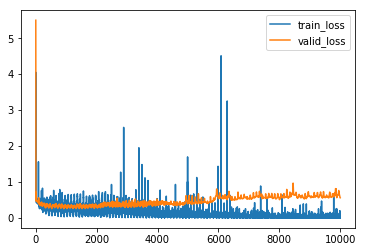

In [5]:
import matplotlib.pyplot as mplot

mplot.plot(train_loss, label='train_loss')
mplot.plot(valid_loss, label='valid_loss')
mplot.legend()
mplot.show()

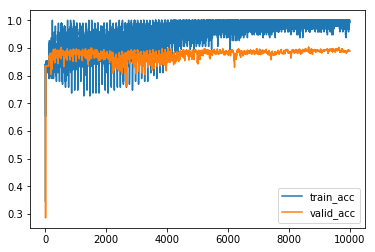

In [6]:
# import matplotlib.pyplot as mplot

mplot.plot(train_acc, label='train_acc')
mplot.plot(valid_acc, label='valid_acc')
mplot.legend()
mplot.show()